# CS506 Final Project - Food Insecurity & Chronic Disease
---

### DATA OVERVIEW

The goal of this analysis is to examine how food access relates to food insecurity and, in turn, how food insecurity may be associated with adverse health outcomes. 
> **Low Access → Food Insecurity → Adverse Health Outcomes**

**Link 1**: Low Access → Food Insecurity
- Data used: `USDA Food Access Research Atlas (Atlas)` (2015) and `Feeding America (MMG)` (2015)
- Year: 2015
- Both datasets align in time, allowing a direct analysis of the association between poor food access and higher food insecurity.

**Link 2**: Food Insecurity → Health Outcomes
- Data used: `MMG` (2017) and `CDC PLACES` 2020 release
  - Both use 2010 Census tract boundaries
  - PLACES 2021 release uses BRFSS 2019/2018 and ACS 2015–2019 or 2014–2018
  - **Rationale**: there is no such PLACES dataset that uses data solely from the year 2019. Assuming gradual change over time, these data provide a reasonable approximation to explore associations between food insecurity and health outcomes.

---

**NOTE:**
- The analyses for the two links use different years; interpretations should account for this temporal mismatch.
- Although not ideal, these are the most suitable datasets available for the project, reflecting real-world data constraints.

In [ ]:
# setup

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

import warnings

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# 1. EDA

## <code style="background:lightblue;color:black">Feeding America</code>

### Initial EDA

- Main metric - **Food Insecurity Rate** (primary dependent variable)
- Other features provide context (cost per meal, income thresholds, and % below SNAP line)
- Child-specific subset could be used for subgroup analysis
- **FIPS**: merge key
  - State FIPS: 2 digits 
  - County FIPS: 3 digits within the state
  - Full FIPS: 5 digits = state + county
- 3,142 unique counties (Google says there are 3,143 in the US)

In [ ]:
mmg = pd.read_excel('./data/raw/feeding_america/MMG2017_2015.xlsx')

In [ ]:
mmg.head()

,FIPS,State,"County, State",2015 Food Insecurity Rate,# of Food Insecure Persons in 2015,Low Threshold in state,Low Threshold Type,High Threshold in state,High Threshold Type,% FI ≤ Low Threshold,% FI Btwn Thresholds,% FI > High Threshold,2015 Child food insecurity rate,# of Food Insecure Children in 2015,% food insecure children in HH w/ HH incomes below 185 FPL in 2015,% food insecure children in HH w/ HH incomes above 185 FPL in 2015,2015 Cost Per Meal,2015 Weighted Annual Food Budget Shortfall
0,1001,AL,"Autauga County, Alabama",0.139,7680,1.3,SNAP,1.85,Other Nutrition Program,0.472,0.221,0.307,0.210,2950,0.73,0.27,3.18,4376000
1,1003,AL,"Baldwin County, Alabama",0.130,25350,1.3,SNAP,1.85,Other Nutrition Program,0.526,0.168,0.306,0.220,9620,0.72,0.28,3.40,15466000
2,1005,AL,"Barbour County, Alabama",0.234,6290,1.3,SNAP,1.85,Other Nutrition Program,0.556,0.236,0.208,0.296,1700,0.80,0.20,3.05,3442000
3,1007,AL,"Bibb County, Alabama",0.161,3650,1.3,SNAP,1.85,Other Nutrition Program,0.538,0.256,0.206,0.250,1230,0.98,0.02,2.89,1888000
4,1009,AL,"Blount County, Alabama",0.113,6510,1.3,SNAP,1.85,Other Nutrition Program,0.640,0.175,0.186,0.239,3260,0.75,0.25,3.02,3528000


In [ ]:
mmg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3142 entries, 0 to 3141
Data columns (total 18 columns):
 #   Column                                                              Non-Null Count  Dtype  
---  ------                                                              --------------  -----  
 0   FIPS                                                                3142 non-null   int64  
 1   State                                                               3142 non-null   object 
 2   County, State                                                       3142 non-null   object 
 3   2015 Food Insecurity Rate                                           3142 non-null   float64
 4   # of Food Insecure Persons in 2015                                  3142 non-null   int64  
 5   Low Threshold in state                                              3142 non-null   float64
 6   Low Threshold Type                                                  3142 non-null   object 
 7   High Threshold 

### Exploring Food Insecurity

Food insecurity seems to be a bigger problem in the **Deep South**, especially in Mississippi, Alabama, Arkansas, and Louisiana. Could this be due to food deserts? On average, about the food insecurity rate in the US on a county level is 14%, but the distribution is right skewed due to these Southern areas, where rates can reach over 30%, and at highest nearly 38%

In [ ]:
# convert FIPS to string and pad with zeros
mmg['FIPS'] = mmg['FIPS'].astype(str).str.zfill(5)

In [ ]:
# 2015 food insecurity rate summary stats
mmg['2015 Food Insecurity Rate'].describe()

count    3142.000000
mean        0.141386
std         0.042360
min         0.034000
25%         0.114000
50%         0.136000
75%         0.163000
max         0.379000
Name: 2015 Food Insecurity Rate, dtype: float64

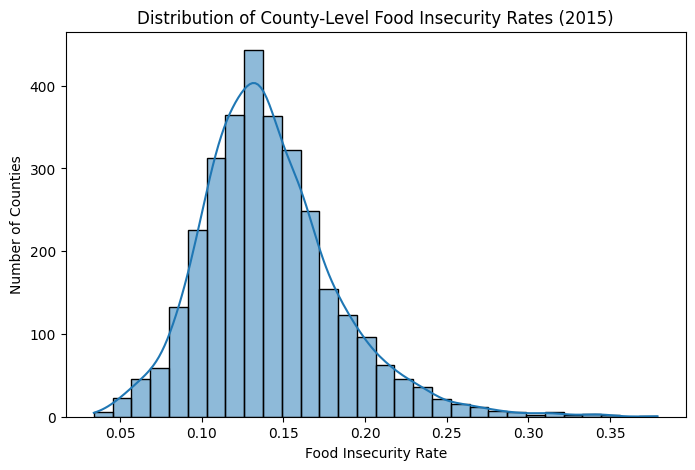

In [ ]:
# food insecurity distribution
plt.figure(figsize = (8,5))
sns.histplot(fi, bins = 30, kde = True)

plt.title('Distribution of County-Level Food Insecurity Rates (2015)')
plt.xlabel('Food Insecurity Rate')
plt.ylabel('Number of Counties')

plt.show()

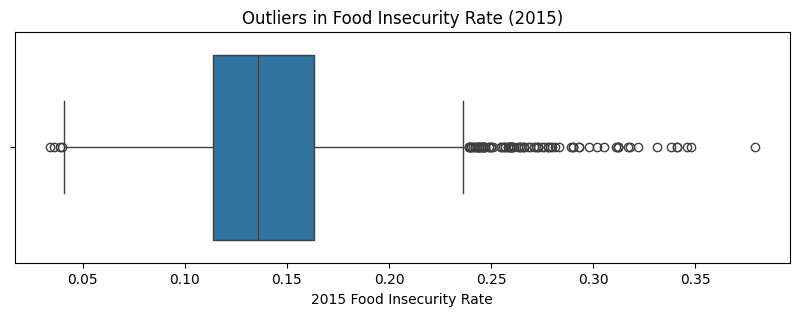

In [ ]:
# boxplot for outliers
plt.figure(figsize = (10,3))
sns.boxplot(x = fi)
plt.title('Outliers in Food Insecurity Rate (2015)')
plt.show()

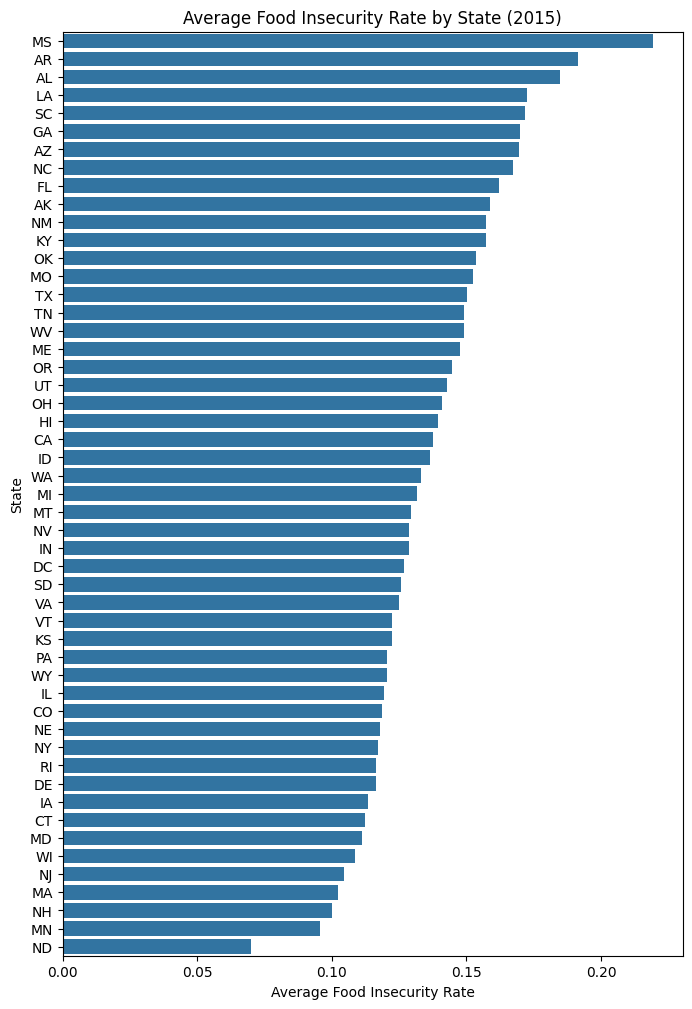

In [ ]:
state_avg = mmg.groupby('State')['2015 Food Insecurity Rate'].mean().sort_values(ascending=False)

plt.figure(figsize = (8, 12))
sns.barplot(y = state_avg.index, x = state_avg.values)
plt.title('Average Food Insecurity Rate by State (2015)')
plt.xlabel('Average Food Insecurity Rate')
plt.ylabel('State')
plt.show()

In [ ]:
state_avg = mmg.groupby('State')['2015 Food Insecurity Rate'].mean().reset_index()

fig = px.choropleth(
    state_avg,
    locations = 'State', 
    locationmode = 'USA-states',
    color = '2015 Food Insecurity Rate',
    scope = 'usa',
    labels = {'2015 Food Insecurity Rate': 'Food Insecurity Rate'},
    title = 'Average Food Insecurity Rate by State (2015)'
)

fig.update_layout(
    title_x = 0.5,
    width = 1000,
    height = 500, 
    margin=dict(l = 20, r = 20, t = 60, b =20)
)

fig.show()

In [ ]:
fig = px.choropleth(
    mmg,
    geojson = "https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json",
    locations = 'FIPS',
    color = '2015 Food Insecurity Rate',
    scope = 'usa',
    labels = {'2015 Food Insecurity Rate': 'Food Insecurity Rate'},
    title = 'Food Insecurity Rate by County (2015)',
)

fig.update_layout(
    title_x = 0.5,
    width = 1000,
    height = 500, 
    margin=dict(l = 20, r = 20, t = 60, b = 20)
)

fig.show()

## <code style="background:lightpink;color:black">USDA</code>

### Initial EDA

This dataset captures low-access and low-income populations at the census tract level, which we aggregate to county FIPS. Insights:

- Key metrics for food access (independent variables)
  - `LILA*`: flags tracts that meet USDA’s *food desert* definition (low income + low access)
  - `LALOWI*`: counts or shares of *low-income individuals* with low access (primary continuous measure of food access)
  - `LAPOP*`: counts of *total population* with low access (control or contextual variable)
  - `LAHU* / LAVehicle*`: people or households *without vehicles* and far from stores (mobility barrier indicators)
- Food access features are measured based on distance thresholds (urban vs rural)
  - Variable suffixes (_half, _1, _10, _20) denote distance thresholds
- Variables for population and __socioeconomic context__:
  - Urban flag
  - Population, housing units, group quarters
  - Poverty rate (and whether the tract is flagged as low income)
  - Median family income
- __Subgroups__ provide contextual insights for who is most affected/vulnerable populations (covariates to understand confounders)
  - Low income
  - Kids
  - Seniors
  - Race (White, Black, Asian, Native Hawaiian and Other Pacific Islander, American Indian and Alaska Native, Multiple, Hispanic or Latino)
  - Vehicle access
  - SNAP
- **Census Tract**: smaller than counties, will later need to aggregate to county FIPS for merging with Feeding America and CDC data
  - State FIPS code (2 digits)
  - County FIPS code (3 digits)
  - Tract code (6 digits)
  - Census tract = state + county + tract (11 digits)
- Aggregations necessary:
  - % low access population per county
  - % low-income, low-access population per county

------


Key measures of “low access” population will be the primary independent variable for the causal pathway: Low Access → Food Insecurity.

Useful documentation: https://www.ers.usda.gov/data-products/food-access-research-atlas/documentation#indicators

In [ ]:
atlas = pd.read_excel('./data/raw/usda_food_access/FoodAccessResearchAtlasData2015.xlsx',
                     sheet_name = 2,
                     dtype = 'str')

FileNotFoundError: [Errno 2] No such file or directory: '../data/raw/usda_food_access/2015/FoodAccessResearchAtlasData2015.xlsx'

In [ ]:
atlas.head()

,CensusTract,State,County,Urban,POP2010,OHU2010,GroupQuartersFlag,NUMGQTRS,PCTGQTRS,LILATracts_1And10,LILATracts_halfAnd10,LILATracts_1And20,LILATracts_Vehicle,HUNVFlag,LowIncomeTracts,PovertyRate,MedianFamilyIncome,LA1and10,LAhalfand10,LA1and20,LATracts_half,LATracts1,LATracts10,LATracts20,LATractsVehicle_20,LAPOP1_10,LAPOP05_10,LAPOP1_20,LALOWI1_10,LALOWI05_10,LALOWI1_20,lapophalf,lapophalfshare,lalowihalf,lalowihalfshare,lakidshalf,lakidshalfshare,laseniorshalf,laseniorshalfshare,lawhitehalf,lawhitehalfshare,lablackhalf,lablackhalfshare,laasianhalf,laasianhalfshare,lanhopihalf,lanhopihalfshare,laaianhalf,laaianhalfshare,laomultirhalf,laomultirhalfshare,lahisphalf,lahisphalfshare,lahunvhalf,lahunvhalfshare,lasnaphalf,lasnaphalfshare,lapop1,lapop1share,lalowi1,lalowi1share,lakids1,lakids1share,laseniors1,laseniors1share,lawhite1,lawhite1share,lablack1,lablack1share,laasian1,laasian1share,lanhopi1,lanhopi1share,laaian1,laaian1share,laomultir1,laomultir1share,lahisp1,lahisp1share,lahunv1,lahunv1share,lasnap1,lasnap1share,lapop10,lapop10share,lalowi10,lalowi10share,lakids10,lakids10share,laseniors10,laseniors10share,lawhite10,lawhite10share,lablack10,lablack10share,laasian10,laasian10share,lanhopi10,lanhopi10share,laaian10,laaian10share,laomultir10,laomultir10share,lahisp10,lahisp10share,lahunv10,lahunv10share,lasnap10,lasnap10share,lapop20,lapop20share,lalowi20,lalowi20share,lakids20,lakids20share,laseniors20,laseniors20share,lawhite20,lawhite20share,lablack20,lablack20share,laasian20,laasian20share,lanhopi20,lanhopi20share,laaian20,laaian20share,laomultir20,laomultir20share,lahisp20,lahisp20share,lahunv20,lahunv20share,lasnap20,lasnap20share,TractLOWI,TractKids,TractSeniors,TractWhite,TractBlack,TractAsian,TractNHOPI,TractAIAN,TractOMultir,TractHispanic,TractHUNV,TractSNAP
0,01001020100,Alabama,Autauga,1,1912,693,0,0,0,0,0,0,0,0,0,10,74750,1,1,1,1,1,0,0,0,1357.48093973123,1732.22546793776,1357.48093973123,322.084611989615,411.69075440563,322.084611989615,1732.22546793776,0.905975663147367,411.69075440563,0.215319432220518,466.426429549697,0.243946877379549,198.82822029374,0.103989654965346,1482.88141720404,0.77556559477199,184.319105652335,0.096401205885113,12.7181206382992,0.006651736735512,0,0,13.9699329382456,0.007306450281509,38.3368966744164,0.020050678176996,39.6950211152579,0.020760994307143,21.5562475419237,0.031105696308692,101.87739790781,0.147009232190203,1357.48093973123,0.709979570989139,322.084611989615,0.168454294973649,363.63838111062,0.190187437819362,162.497245970298,0.084988099356851,1161.80255254392,0.607637318276114,147.487665743276,0.077137900493345,11.015106447583,0.00576103893702,0,0,9.99659218850501,0.005228343194825,27.1790304430178,0.014214974081076,29.7155356679722,0.015541598152705,9.77285467438832,0.014102243397386,79.5468434111098,0.114786209828441,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,448,507,221,1622,217,14,0,14,45,44,26,112
1,01001020200,Alabama,Autauga,1,2170,743,0,181,0.0834101,0,0,0,0,0,0,18.1999999999999,51875,0,1,0,1,0,0,0,0,483.429682502523,1410.37482770578,483.429682502523,145.14141792804,475.306031379848,145.14141792804,1410.37482770578,0.64994231691511,475.306031379848,0.219035037502234,448.163511756807,0.206526963943229,139.30539013847,0.064196032321876,412.291348965605,0.189996013348205,945.317795821814,0.435630320655214,4.00000012698183,0.001843318030867,0,0,4.71758192859852,0.002174000888755,44.0481012072123,0.020298664150789,34.587909407739,0.015939128759327,58.628965407639,0.078908432580941,127.367744830262,0.17142361349968,483.429682502523,0.222778655531117,145.14141792804,0.066885446049788,174.770469508133,0.080539386870108,50.9768215618096,0.023491622839544,128.16099537909,0.059060366534143,335.447720738127,0.154584203105128,1.59092694451101,0.000733146057378,0,0,0.26351073384285,0.0001214335179,17.9665312720462,0.008279507498639,11.1735897362232,0.005149119694112,21.63833650382,0.029122929345653,41.70096444955

In [ ]:
atlas.shape

(72864, 147)

In [ ]:
atlas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72864 entries, 0 to 72863
Columns: 147 entries, CensusTract to TractSNAP
dtypes: object(147)
memory usage: 81.7+ MB


In [ ]:
list(atlas.columns)

['CensusTract',
 'State',
 'County',
 'Urban',
 'POP2010',
 'OHU2010',
 'GroupQuartersFlag',
 'NUMGQTRS',
 'PCTGQTRS',
 'LILATracts_1And10',
 'LILATracts_halfAnd10',
 'LILATracts_1And20',
 'LILATracts_Vehicle',
 'HUNVFlag',
 'LowIncomeTracts',
 'PovertyRate',
 'MedianFamilyIncome',
 'LA1and10',
 'LAhalfand10',
 'LA1and20',
 'LATracts_half',
 'LATracts1',
 'LATracts10',
 'LATracts20',
 'LATractsVehicle_20',
 'LAPOP1_10',
 'LAPOP05_10',
 'LAPOP1_20',
 'LALOWI1_10',
 'LALOWI05_10',
 'LALOWI1_20',
 'lapophalf',
 'lapophalfshare',
 'lalowihalf',
 'lalowihalfshare',
 'lakidshalf',
 'lakidshalfshare',
 'laseniorshalf',
 'laseniorshalfshare',
 'lawhitehalf',
 'lawhitehalfshare',
 'lablackhalf',
 'lablackhalfshare',
 'laasianhalf',
 'laasianhalfshare',
 'lanhopihalf',
 'lanhopihalfshare',
 'laaianhalf',
 'laaianhalfshare',
 'laomultirhalf',
 'laomultirhalfshare',
 'lahisphalf',
 'lahisphalfshare',
 'lahunvhalf',
 'lahunvhalfshare',
 'lasnaphalf',
 'lasnaphalfshare',
 'lapop1',
 'lapop1share',
 

In [ ]:
atlas.describe()

,CensusTract,State,County,Urban,POP2010,OHU2010,GroupQuartersFlag,NUMGQTRS,PCTGQTRS,LILATracts_1And10,LILATracts_halfAnd10,LILATracts_1And20,LILATracts_Vehicle,HUNVFlag,LowIncomeTracts,PovertyRate,MedianFamilyIncome,LA1and10,LAhalfand10,LA1and20,LATracts_half,LATracts1,LATracts10,LATracts20,LATractsVehicle_20,LAPOP1_10,LAPOP05_10,LAPOP1_20,LALOWI1_10,LALOWI05_10,LALOWI1_20,lapophalf,lapophalfshare,lalowihalf,lalowihalfshare,lakidshalf,lakidshalfshare,laseniorshalf,laseniorshalfshare,lawhitehalf,lawhitehalfshare,lablackhalf,lablackhalfshare,laasianhalf,laasianhalfshare,lanhopihalf,lanhopihalfshare,laaianhalf,laaianhalfshare,laomultirhalf,laomultirhalfshare,lahisphalf,lahisphalfshare,lahunvhalf,lahunvhalfshare,lasnaphalf,lasnaphalfshare,lapop1,lapop1share,lalowi1,lalowi1share,lakids1,lakids1share,laseniors1,laseniors1share,lawhite1,lawhite1share,lablack1,lablack1share,laasian1,laasian1share,lanhopi1,lanhopi1share,laaian1,laaian1share,laomultir1,laomultir1share,lahisp1,lahisp1share,lahunv1,lahunv1share,lasnap1,lasnap1share,lapop10,lapop10share,lalowi10,lalowi10share,lakids10,lakids10share,laseniors10,laseniors10share,lawhite10,lawhite10share,lablack10,lablack10share,laasian10,laasian10share,lanhopi10,lanhopi10share,laaian10,laaian10share,laomultir10,laomultir10share,lahisp10,lahisp10share,lahunv10,lahunv10share,lasnap10,lasnap10share,lapop20,lapop20share,lalowi20,lalowi20share,lakids20,lakids20share,laseniors20,laseniors20share,lawhite20,lawhite20share,lablack20,lablack20share,laasian20,laasian20share,lanhopi20,lanhopi20share,laaian20,laaian20share,laomultir20,laomultir20share,lahisp20,lahisp20share,lahunv20,lahunv20share,lasnap20,lasnap20share,TractLOWI,TractKids,TractSeniors,TractWhite,TractBlack,TractAsian,TractNHOPI,TractAIAN,TractOMultir,TractHispanic,TractHUNV,TractSNAP
count,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864,72864
unique,72864,51,1837,2,9123,4100,2,2221,39312,2,2,2,2,2,2,829,38925,2,2,2,2,2,2,2,2,41252,57422,35465,41031,57158,35257,67690,67654,67357,67357,67444,67472,67400,67425,67587,67599,66460,66967,63776,65717,25757,36995,59861,64321,67361,67411,67342,67411,64909,64909,65715,65715,51514,51506,51224,51224,51117,51136,51075,51097,51377,51384,49004,49515,46953,48057,17436,22811,43486,45343,50470,50519,50480,50534,47743,47743,49954,49954,7387,7386,7364,7364,7201,7202,7230,7231,7362,7363,4532,4796,3772,4056,989,1176,4592,4776,6241,6269,5995,6024,6649,6649,7331,7331,1354,1354,1344,1344,1216,1216,1263,1263,1332,1332,469,493,506,547,163,187,767,782,999,1003,978,985,1149,1149,1330,1330,5137,3495,2169,8168,4383,2553,424,972,2979,5256,1601,1200
top,01001020100,California,Los Angeles,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0
freq,1,8044,2343,55172,333,439,72348,27573,27573,63619,52308,64759,61995,56550,41994,780,838,45337,49725,48154,46520,48542,69659,72476,56226,31608,15441,37394,31834,15707,37608,5171,5171,5508,5508,5391,5391,5440,5440,5263,5263,5894,5894,7125,7

In [ ]:
# ensuring all counties are represented

atlas['County, State'] = atlas['County'] + ', ' + atlas['State']
atlas['County, State'].describe()

count                       72864
unique                       3141
top       Los Angeles, California
freq                         2343
Name: County, State, dtype: object

In [ ]:
id_cols = ['CensusTract', 'State', 'County', 'County, State']

# convert non-id columns to numeric
for col in atlas.columns:
    if col not in id_cols:
        atlas[col] = pd.to_numeric(atlas[col], errors = 'coerce')

In [ ]:
# US population from 2010 census
atlas['POP2010'].sum()

308745538

### Tract Flags - Access, Income, & Distance
- Distance thresholds define food deserts differently in urban vs. rural areas:
  - Urban tracts are considered food deserts if low access is 1/2 mile or 1 mile from a supermarket
  - Rural tracts are considered food deserts if low access is 10 or 20 miles from a supermarket
- Effect of distance on counts:
  - Shorter distances (urban 1/2 mile & rural 10 miles) flag more tracts as food deserts - these are **upper bounds**
  - Longer distances (urban 1 mile & rural 20 miles) flag fewer tracts - these are **lower bounds** and are more extreme
- Using vehicle access as a definition is a fundamentally different metric
  - Measures functional access, not just physical distance
  - Not comparable to other distance metrics
- **Linear combination** is evident, metrics like LAhalfand10 or LA1and10 are essentially combinations of urban and rural definitions
- This pattern of lower and upper bounds based on distance holds true for low income AND low access tracts

------

**Findings**: although 33-68% of tracts are considered low access, 11-28% of tracts are considered food deserts due to also being considered low income
- 14-35% of urban tracts in the US are food deserts
- 1-8% of rural tracts in the US are food deserts
- 93-98% of food deserts are urban tracts

In [ ]:
# low access tracts
cols = ['LA1and10', 'LAhalfand10', 'LA1and20', 'LATracts_half',
        'LATracts1', 'LATracts10', 'LATracts20', 'LATractsVehicle_20']

# sum of flags based on urbanicity
urban = atlas[atlas['Urban'] == 1][cols].sum()
rural = atlas[atlas['Urban'] == 0][cols].sum()

# aggregate summary
access = pd.DataFrame({'Urban': urban, 
                       'Rural': rural,
                       'Total': urban + rural,
                       '% of Tracts': (urban + rural) / 72864
                      })
access

,Urban,Rural,Total,% of Tracts
LA1and10,24322,3205,27527,0.377786
LAhalfand10,46520,3205,49725,0.682436
LA1and20,24322,388,24710,0.339125
LATracts_half,46520,0,46520,0.638450
LATracts1,24322,0,24322,0.333800
LATracts10,0,3205,3205,0.043986
LATracts20,0,388,388,0.005325
LATractsVehicle_20,13051,3587,16638,0.228343


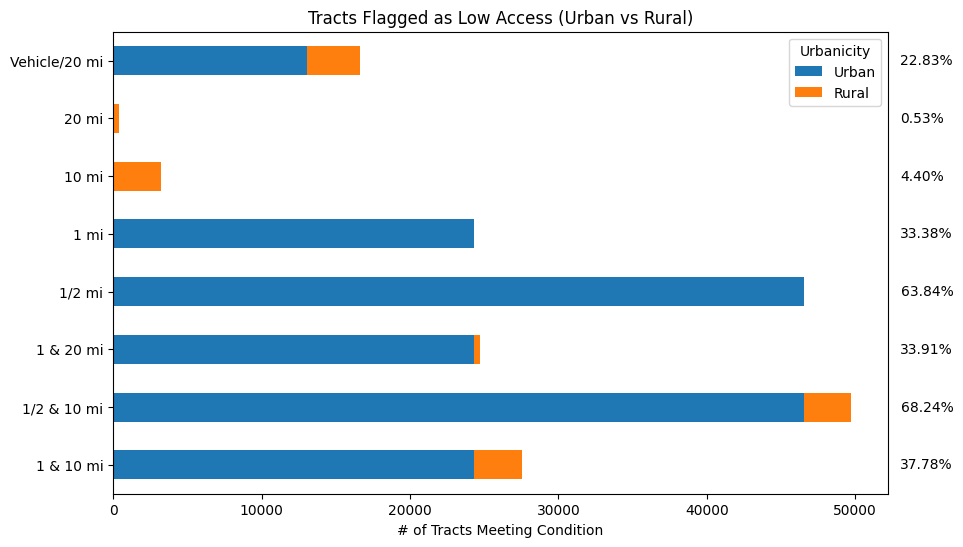

In [ ]:
# stacked bar plot
ax = access[['Urban', 'Rural']].plot(kind = 'barh', stacked = True, figsize = (10,6))

labels = ['1 & 10 mi', '1/2 & 10 mi', '1 & 20 mi', '1/2 mi',
          '1 mi', '10 mi', '20 mi', 'Vehicle/20 mi']
plt.yticks(ticks = range(len(labels)), labels = labels)

plt.xlabel('# of Tracts Meeting Condition')
plt.title('Tracts Flagged as Low Access (Urban vs Rural)')
plt.legend(title = 'Urbanicity')

# display proportions
for i, label in enumerate(access.index):
    total = access.loc[label]['% of Tracts'] *100
    ax.text(total + 53000, i, f'{total:.2f}%', va='center')

plt.show()

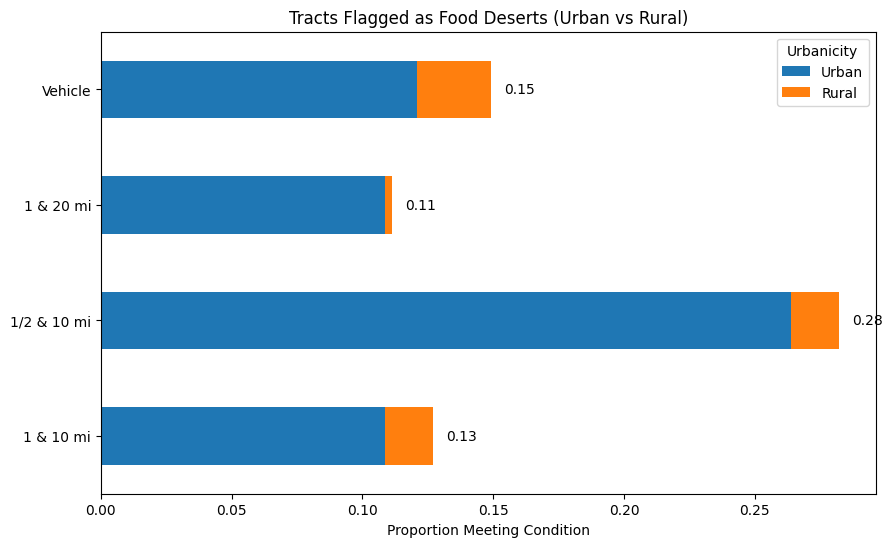

In [ ]:
# low access, low income tracts
cols = ['LILATracts_1And10', 
        'LILATracts_halfAnd10', 
        'LILATracts_1And20', 
        'LILATracts_Vehicle']

# aggregating based on urbanicity
urban = atlas[atlas['Urban'] == 1][cols].sum()
rural = atlas[atlas['Urban'] == 0][cols].sum()

lila = pd.DataFrame({'Urban': urban / 72864, 'Rural': rural / 72864})

# stacked bar plot
ax = lila.plot(kind = 'barh', stacked = True, figsize = (10,6))

labels = ['1 & 10 mi', '1/2 & 10 mi', '1 & 20 mi', 'Vehicle']
plt.yticks(ticks = range(len(labels)), labels=labels)

plt.xlabel('Proportion Meeting Condition')
plt.title('Tracts Flagged as Food Deserts (Urban vs Rural)')
plt.legend(title = 'Urbanicity')

# display proportions
for i, total in enumerate((lila['Urban'] + lila['Rural'])):
    ax.text(total + 0.005, i, f'{total:.2f}', va='center')

In [ ]:
# spectrum of thresholds
definitions = {
    'Lower Bound (1 & 20 mi)': 'LILATracts_1And20',
    'Upper Bound (1/2 & 10 mi)': 'LILATracts_halfAnd10',
    'Vehicle Access': 'LILATracts_Vehicle'
}

tract_urb_pct = pd.DataFrame(columns = ['% Urban Tracts Flagged', '% Rural Tracts Flagged', '% Total Tracts Flagged'], index = definitions.keys())

# summarize % of tracts flagged by urbanicity
for name, col in definitions.items():
    urban_count = atlas[atlas['Urban'] == 1][col].sum()
    rural_count = atlas[atlas['Urban'] == 0][col].sum()
    tract_urb_pct.loc[name, '% Urban Tracts Flagged'] = urban_count / atlas[atlas['Urban'] == 1].shape[0] * 100
    tract_urb_pct.loc[name, '% Rural Tracts Flagged'] = rural_count / atlas[atlas['Urban'] == 0].shape[0] * 100
    tract_urb_pct.loc[name, '% Total Tracts Flagged'] = (urban_count + rural_count) / 72864 * 100

tract_urb_pct = tract_urb_pct.astype(float)
tract_urb_pct

,% Urban Tracts Flagged,% Rural Tracts Flagged,% Total Tracts Flagged
Lower Bound (1 & 20 mi),14.327920,1.130454,11.123463
Upper Bound (1/2 & 10 mi),34.829261,7.574045,28.211462
Vehicle Access,15.951932,11.688899,14.916831


### Populations - Access, Income & Distance

- **21-50%** of the population had low access to food in 2015
- **6-16**% of people lived in a food desert (LILA)
- Most of these populations were in urban tracts because they are densely populated
  - 96-98% of people living in a food desert were in urban tracts
- The distributions of low-access vs LILA populations were extremely right skewed and heavily concentrated near 0
  - Most tracts (especially rural) have very few or no residents living far from supermarkets
  - A small number of tracts have very large low-access populations (thousands)
  - Massive outliers dominate the overall count

In [ ]:
# low access vs. food desert populations at various thresholds
la_cols = ['LAPOP1_10', 'LAPOP05_10', 'LAPOP1_20']
lila_cols = ['LALOWI1_10', 'LALOWI05_10', 'LALOWI1_20']
labels = ['1 & 10 mi', '1/2 & 10 mi', '1 & 20 mi']

# total population
pop_total = atlas['POP2010'].sum()

# aggregating by urbanicity
for i in [la_cols, lila_cols]:
    urban_la = atlas.loc[atlas['Urban']==1, i].sum() / 1e6
    rural_la = atlas.loc[atlas['Urban']==0, i].sum() / 1e6
    total_la = atlas[i].sum() / 1e6

# build summary table
warnings.filterwarnings("ignore")

cols = pd.MultiIndex.from_arrays([
    ['Low Access Populations (M)']*4 + ['LILA Populations (M)']*4,
    ['Urban', 'Rural', 'Total', '% National']*2
])

data = []
for i in range(len(labels)):
    row = [
        f'{round(urban_low[i], 2)} mil',
        f'{round(rural_low[i], 2)} mil',
        f'{round(total_low[i], 2)} mil',
        f'{round(total_low[i]*1e6/pop_total*100, 2)} %',
        f'{round(urban_lila[i], 2)} mil',
        f'{round(rural_lila[i], 2)} mil',
        f'{round(total_lila[i], 2)} mil',
        f'{round(total_lila[i]*1e6/pop_total*100, 2)} %'
    ]
    data.append(row)

summary = pd.DataFrame(data, index=labels, columns=cols)
summary

Low Access Populations (M)                                   \
                                 Urban     Rural       Total % National   
1 & 10 mi                    64.13 mil  5.14 mil   69.27 mil    22.43 %   
1/2 & 10 mi                  149.8 mil  5.14 mil  154.94 mil    50.18 %   
1 & 20 mi                    64.13 mil  0.61 mil   64.73 mil    20.97 %   

            LILA Populations (M)                                  
                           Urban     Rural      Total % National  
1 & 10 mi              18.17 mil  2.05 mil  20.22 mil     6.55 %  
1/2 & 10 mi            47.73 mil  2.05 mil  49.78 mil    16.12 %  
1 & 20 mi              18.17 mil  0.28 mil  18.45 mil     5.97 %

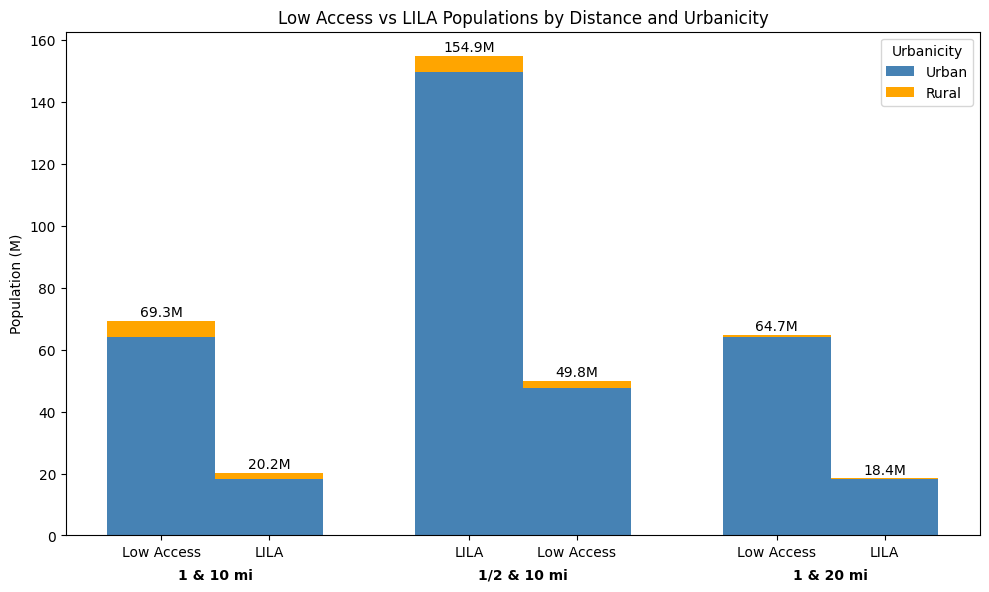

In [ ]:
# defining values for stacked, grouped bar chart
subgroups = ['Low Access', 'LILA']

urban_low = atlas.loc[atlas['Urban']==1, la_cols].sum() / 1e6
rural_low = atlas.loc[atlas['Urban']==0, la_cols].sum() / 1e6
total_low = urban_low + rural_low

urban_lila = atlas.loc[atlas['Urban']==1, lila_cols].sum() / 1e6
rural_lila = atlas.loc[atlas['Urban']==0, lila_cols].sum() / 1e6
total_lila = urban_lila + rural_lila

# creating plot
fig, ax = plt.subplots(figsize = (10, 6))

# positions for bars
x = np.arange(len(labels))
width = 0.35 
x_low = x - width/2
x_lila = x + width/2

# stacked bars
ax.bar(x_low, urban_low, width, label='Urban', color = 'steelblue')
ax.bar(x_low, rural_low, width, label='Rural', bottom = urban_low, color = 'orange')
ax.bar(x_lila, urban_lila, width, color = 'steelblue')
ax.bar(x_lila, rural_lila, width, bottom = urban_lila, color='orange')

# annotate totals
for i in range(len(labels)):
    ax.text(x_low[i], total_low[i] + 0.5, f'{total_low[i]:.1f}M', ha='center', va='bottom')
    ax.text(x_lila[i], total_lila[i] + 0.5, f'{total_lila[i]:.1f}M', ha='center', va='bottom')

# X-axis: hierarchical labels
ax.set_xticks(np.concatenate([x_low, x_lila]))
ax.set_xticklabels(subgroups * len(labels), rotation=0)

# plot labels
for i, label in enumerate(labels):
    ax.text(x[i], -10.5, label, ha = 'center', va = 'top', fontweight = 'bold')

ax.set_ylabel('Population (M)')
ax.set_title('Low Access vs LILA Populations by Distance and Urbanicity')
ax.legend(title = 'Urbanicity')

plt.tight_layout()
plt.show()

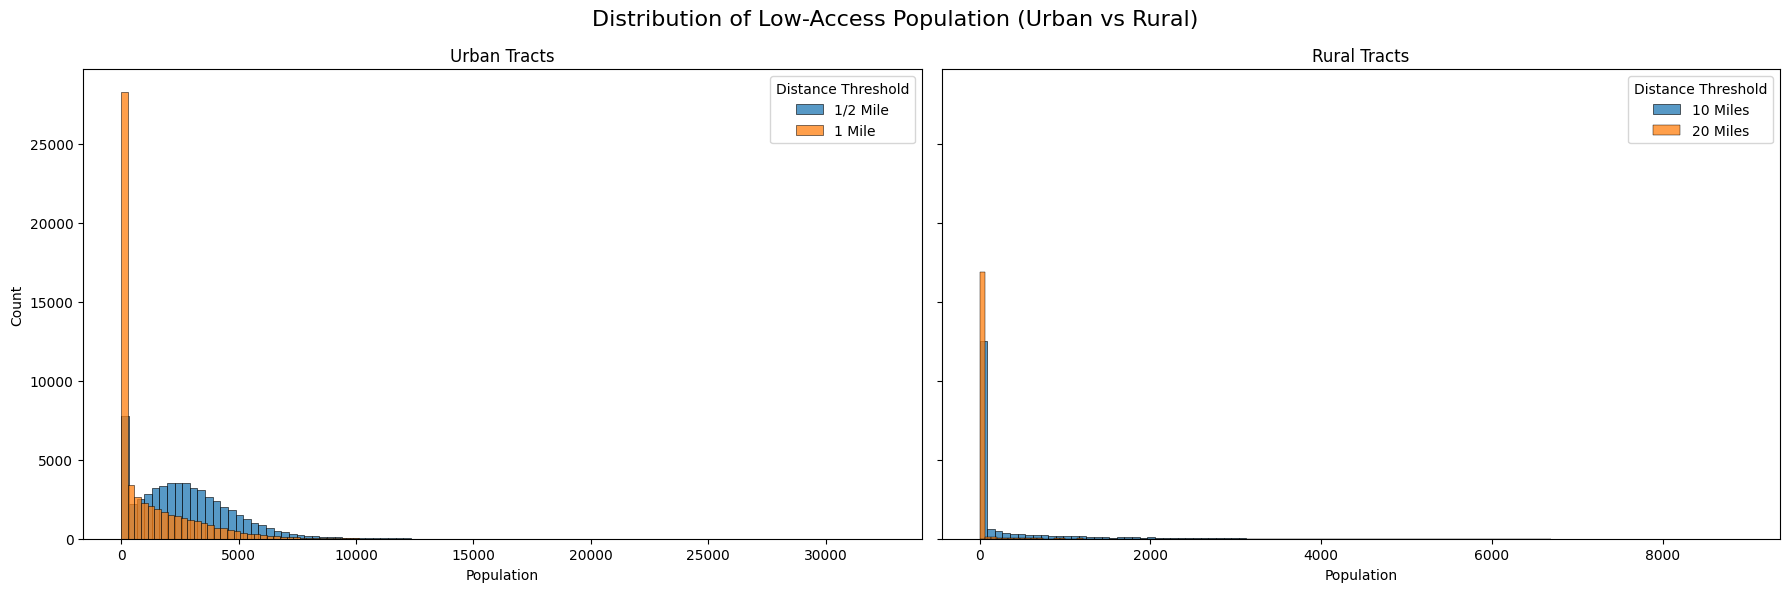

In [ ]:
cols = ['LAPOP1_10', 'LAPOP05_10', 'LAPOP1_20']

fig, axes = plt.subplots(1, 2, figsize = (18, 6), sharey = True)

# urban
sns.histplot(data = atlas[atlas['Urban'] == 1], x = cols[1], bins = 100, label = '1/2 Mile', ax = axes[0])
sns.histplot(data = atlas[atlas['Urban'] == 1], x = cols[0], bins = 100, label = '1 Mile', ax = axes[0])

# rural
sns.histplot(data = atlas[atlas['Urban'] == 0], x = cols[1], bins = 100, label = '10 Miles', ax=axes[1])
sns.histplot(data = atlas[atlas['Urban'] == 0], x = cols[2], bins = 100, label = '20 Miles', ax=axes[1])

# urban plot labels
axes[0].set_title('Urban Tracts')
axes[0].set_xlabel('Population')
axes[0].legend(title = 'Distance Threshold')

# rural plot labels
axes[1].set_title('Rural Tracts')
axes[1].set_xlabel('Population')
axes[1].legend(title = 'Distance Threshold')

fig.suptitle('Distribution of Low-Access Population (Urban vs Rural)', fontsize = 16)

plt.tight_layout()
plt.show()

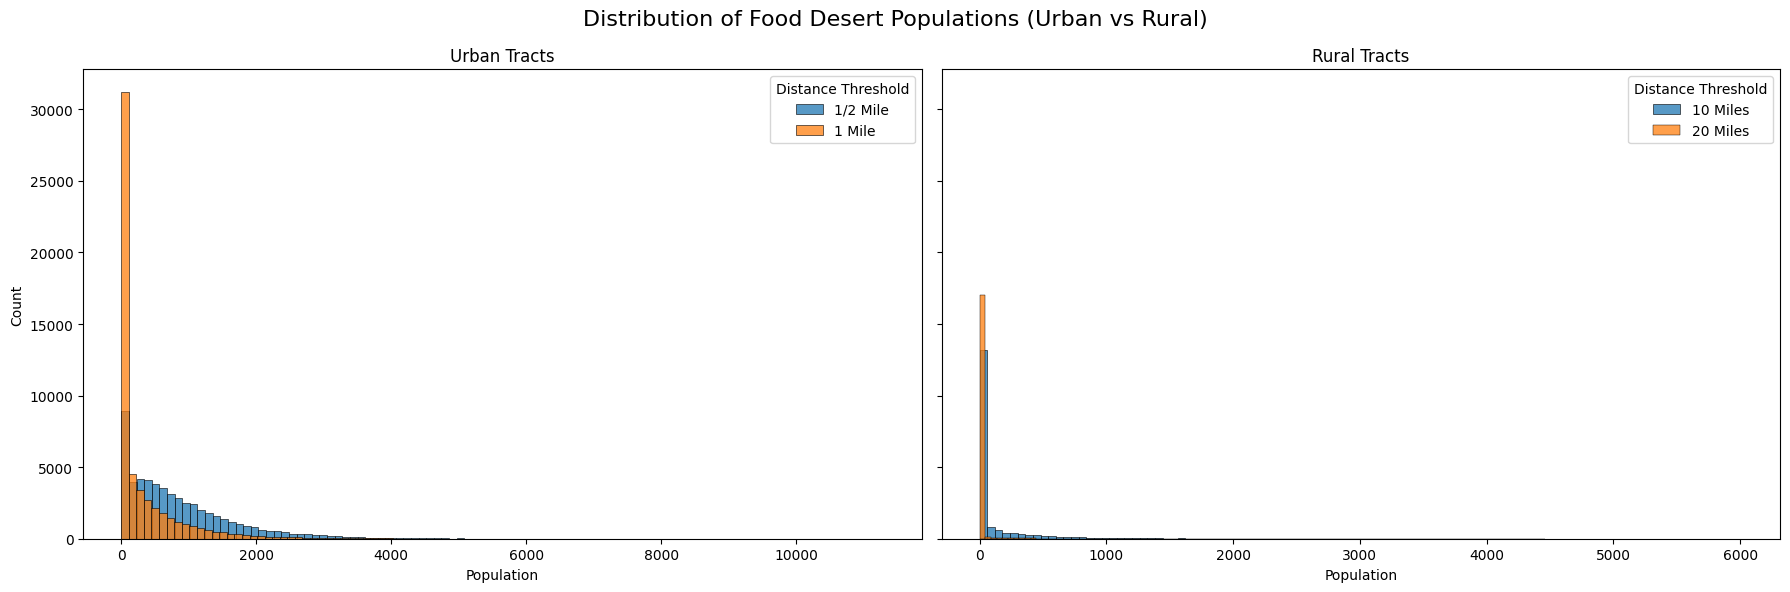

In [ ]:
cols = ['LALOWI1_10', 'LALOWI05_10', 'LALOWI1_20']

fig, axes = plt.subplots(1, 2, figsize = (18, 6), sharey = True)

# urban
sns.histplot(data = atlas[atlas['Urban'] == 1], x = cols[1], bins = 100, label = '1/2 Mile', ax = axes[0])
sns.histplot(data = atlas[atlas['Urban'] == 1], x = cols[0], bins = 100, label = '1 Mile', ax = axes[0])

# rural
sns.histplot(data = atlas[atlas['Urban'] == 0], x = cols[1], bins = 100, label = '10 Miles', ax=axes[1])
sns.histplot(data = atlas[atlas['Urban'] == 0], x = cols[2], bins = 100, label = '20 Miles', ax=axes[1])

# urban plot labels
axes[0].set_title('Urban Tracts')
axes[0].set_xlabel('Population')
axes[0].legend(title = 'Distance Threshold')

# rural plot labels
axes[1].set_title('Rural Tracts')
axes[1].set_xlabel('Population')
axes[1].legend(title = 'Distance Threshold')

fig.suptitle('Distribution of Food Desert Populations (Urban vs Rural)', fontsize = 16)

plt.tight_layout()
plt.show()

### Disparities
- Native American populations are at a huge disparity, **25 times more likely** to live in low-access rural areas with a 20 mile threshold.
- Black and Asian rural populations with a 20 mile threshold show a strong disparity in the opposite direction
- In rural areas, white, low-income, senior, and SNAP populations are more vulnerable
- In urban areas, Native American and white populations are slightly more vulnerable

In [ ]:
atlas = atlas.rename(columns={'TractHispanic': 'TractHisp'})

# helper function
def compute_disparities(threshold):
    """
    Compute nationwide disparity index for each demographic group at a given threshold.
    
    Parameters:
        threshold (str): Distance threshold ('half', '1', '10', '20').
        
    Returns:
        pd.DataFrame: Disparity results with LA_Share, Pop_Share, and Disparity_Index.
    """
    groups = [
        'LOWI', 'Kids', 'Seniors', 'White', 'Black', 'Asian', 
        'NHOPI', 'AIAN', 'OMultir', 'Hisp', 'HUNV', 'SNAP']
    
    disparities = pd.DataFrame(columns=['Group', 'Threshold', 'LA_Share', 'Pop_Share', 'Disparity_Index'])
    
    for g in groups:
        group_la_var = f'la{g.lower()}{threshold}'     
        total_la_var = f'lapop{threshold}' 
        tract_var = f'Tract{g}'     

        total_group_la = atlas[group_la_var].sum()
        total_group_pop = atlas[tract_var].sum()
        total_la = atlas[total_la_var].sum()
        total_pop = atlas['POP2010'].sum()

        prop_la = total_group_la / total_la
        prop_pop = total_group_pop / total_pop
        disparity_index = prop_la / prop_pop 

        disparities.loc[len(disparities)] = [g, threshold, prop_la, prop_pop, disparity_index]

    return disparities.sort_values('Disparity_Index', ascending = False)


In [ ]:
compute_disparities('1')

,Group,Threshold,LA_Share,Pop_Share,Disparity_Index
7,AIAN,1,0.011871,0.009497,1.249962
3,White,1,0.815288,0.724070,1.125980
2,Seniors,1,0.135958,0.130425,1.042425
1,Kids,1,0.244283,0.240267,1.016711
0,LOWI,1,0.306085,0.342495,0.893692
11,SNAP,1,0.042150,0.048857,0.862718
6,NHOPI,1,0.001276,0.001749,0.729799
4,Black,1,0.091417,0.126089,0.725018
8,OMultir,1,0.054951,0.091067,0.603411
9,Hisp,1,0.095300,0.163493,0.582898


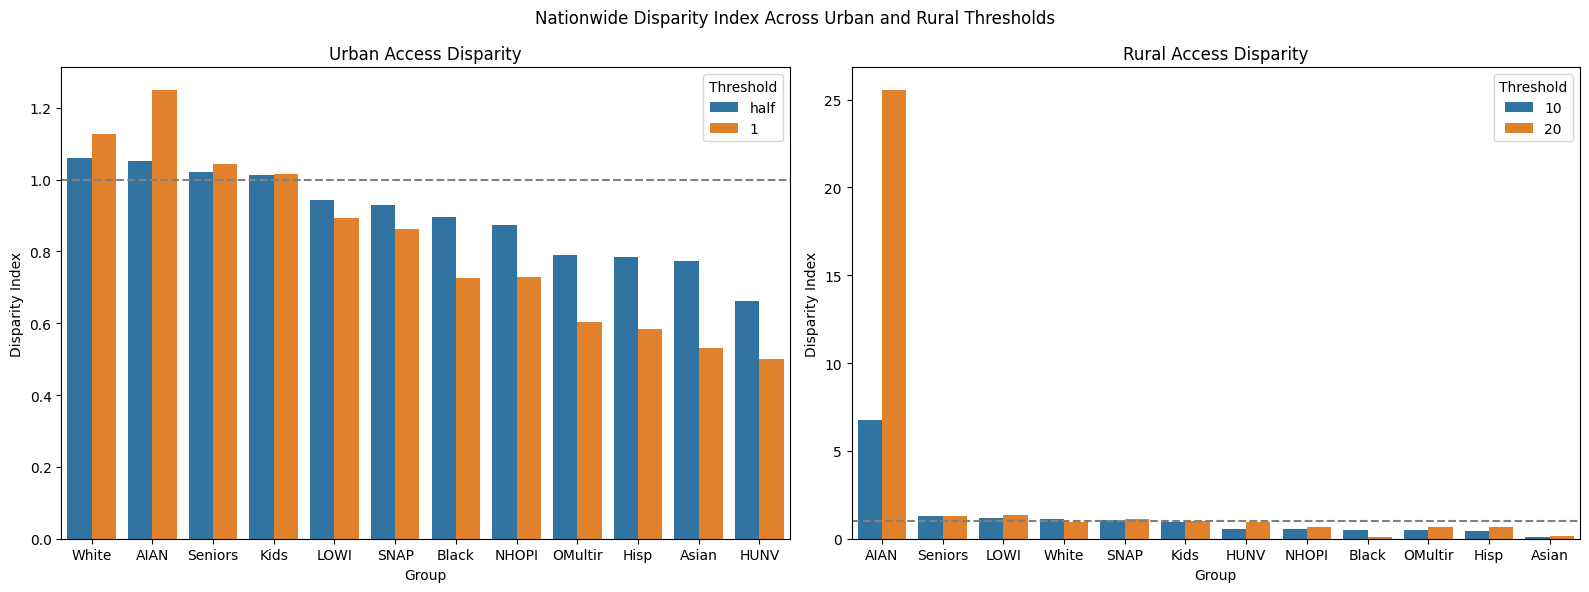

In [ ]:
# compute disparities for all thresholds
thresholds = ['half', '1', '10', '20']
disparity_table = pd.concat([compute_disparities(t) for t in thresholds], ignore_index=True)
disparity_table['Disparity_Index'] = disparity_table['Disparity_Index'].astype(float)

# urban and rural subsets
urban = disparity_table[disparity_table['Threshold'].isin(['half', '1'])]
rural = disparity_table[disparity_table['Threshold'].isin(['10', '20'])]

# plot
fig, axes = plt.subplots(1, 2, figsize = (16, 6))

# Urban plot
sns.barplot(data = urban, x = 'Group', y = 'Disparity_Index', hue = 'Threshold', ax = axes[0])
axes[0].axhline(1, color = 'gray', linestyle = '--')
axes[0].set_title('Urban Access Disparity')
axes[0].set_ylabel('Disparity Index')

# Rural plot
sns.barplot(data = rural, x = 'Group', y = 'Disparity_Index', hue = 'Threshold', ax = axes[1])
axes[1].axhline(1, color = 'gray', linestyle = '--')
axes[1].set_title('Rural Access Disparity')
axes[1].set_ylabel('Disparity Index')

plt.suptitle('Nationwide Disparity Index Across Urban and Rural Thresholds')

plt.tight_layout()
plt.show()

### Mapping
- The **Southeast** seems to have higher proportions of people in food deserts or with low access to food

In [ ]:
# deriving county ID (FIPS)
atlas['StateFIPS'] = atlas['CensusTract'].str[:2]
atlas['CountyFIPS'] = atlas['CensusTract'].str[2:5]
atlas['FIPS'] = atlas['StateFIPS'] + atlas['CountyFIPS']

In [ ]:
# aggregating metrics of interest for threshold = half
county_metrics = atlas.groupby('FIPS').agg(
    pop2010 = ('POP2010', 'sum'),
    la_pop = ('lapop1', 'sum'),          # example threshold; can repeat for other thresholds
    la_low_income = ('lalowi1', 'sum'),
    num_tracts = ('CensusTract', 'count'),
    num_lila_tracts=('LILATracts_1And20', 'sum')  # count of tracts flagged as food desert
).reset_index()

# Compute percentages
county_metrics['pct_low_access'] = county_metrics['la_pop'] / county_metrics['pop2010']
county_metrics['pct_low_income_low_access'] = county_metrics['la_low_income'] / county_metrics['pop2010']
county_metrics['pct_tracts_food_desert'] = county_metrics['num_lila_tracts'] / county_metrics['num_tracts']

In [ ]:
fig1 = px.choropleth(
    county_metrics, 
    geojson = "https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json", 
    locations='FIPS', 
    color = 'pct_low_access',
    range_color = (county_metrics['pct_low_access'].min(), county_metrics['pct_low_access'].max()),
    scope = "usa",
    labels = {'pct_low_access':'% Low Access Pop'},
    color_continuous_scale=px.colors.sequential.Turbo[::-1]
)

fig1.update_layout(
    title_text = '% of County Population with Low Access to Food (10 mi & 20 mi)',
    title_x = 0.5,
    width = 1000,
    height = 500, 
    margin = dict(l = 20, r = 20, t = 60, b = 20)
)

fig1.show()

In [ ]:
fig2 = px.choropleth(
    county_metrics, 
    geojson = "https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json", 
    locations='FIPS', 
    color = 'pct_low_income_low_access',
    range_color = (county_metrics['pct_low_income_low_access'].min(), county_metrics['pct_low_income_low_access'].max()),
    scope = "usa",
    labels = {'pct_low_income_low_access':'% Food Desert Pop'},
    color_continuous_scale=px.colors.sequential.Magma
)

fig2.update_layout(
    title_text = '% of County Population in a Food Desert',
    title_x = 0.5,
    width = 1000,
    height = 500, 
    margin = dict(l = 20, r = 20, t = 60, b = 20)
)

fig2.show()

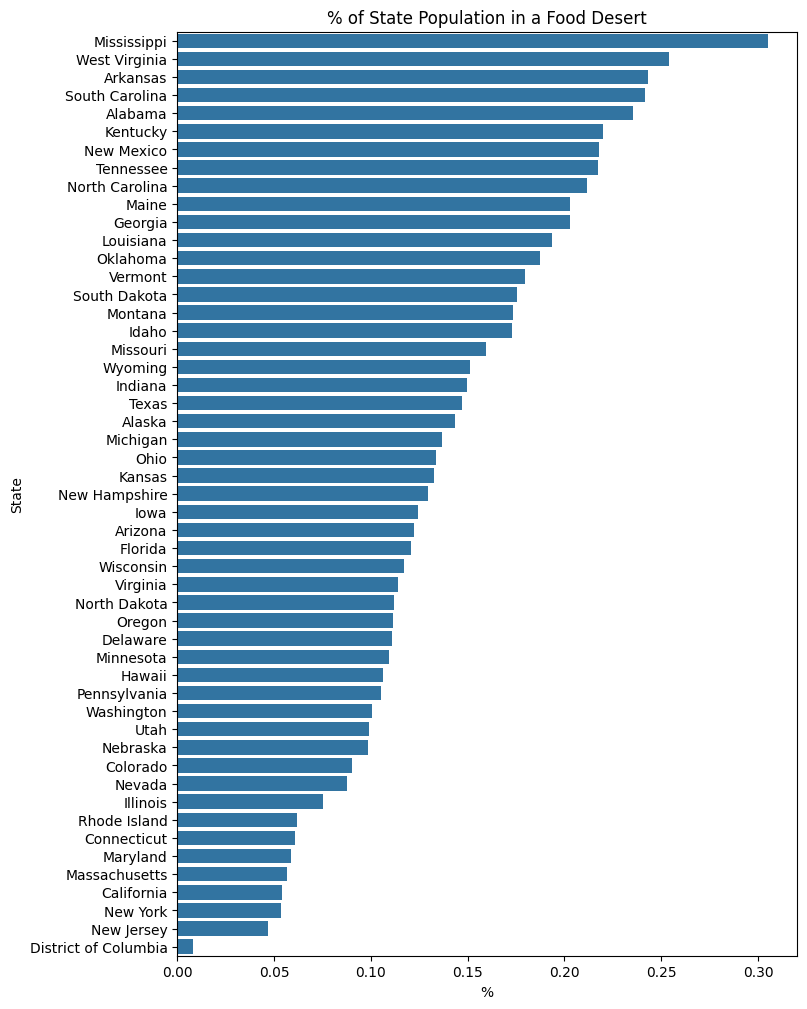

In [ ]:
state_LILA = atlas.groupby('State')['lalowi1'].sum()
state_total_pop = atlas.groupby('State')['POP2010'].sum()
state_avg = state_LILA / state_total_pop

state_avg = state_avg.sort_values(ascending = False)

plt.figure(figsize = (8, 12))
sns.barplot(y = state_avg.index, x = state_avg.values)
plt.title('% of State Population in a Food Desert')
plt.xlabel('%')
plt.ylabel('State')
plt.show()

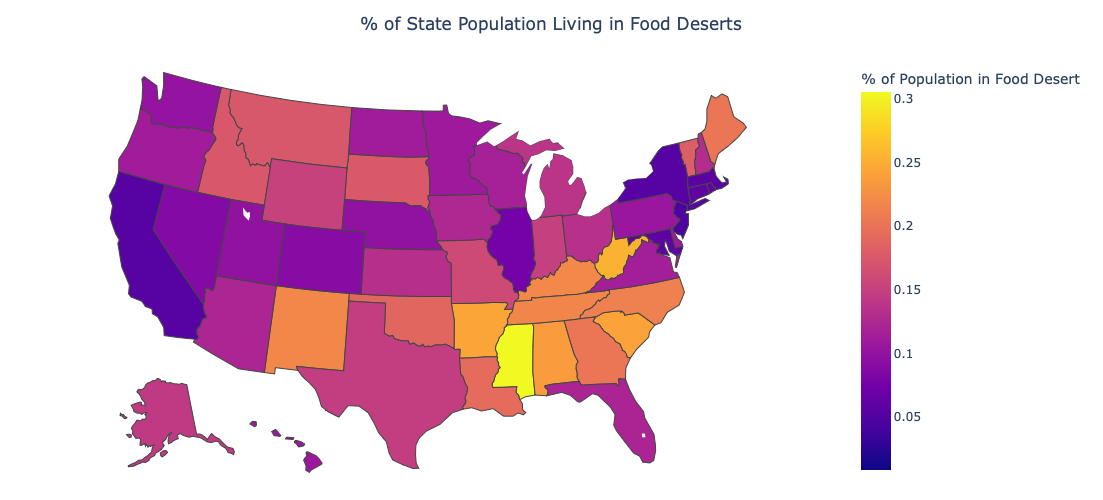

In [ ]:
state_df = state_avg.reset_index()
state_df.columns = ['State', 'FoodDesertRate']

state_abbrev = {
    'Alabama': 'AL', 'Alaska': 'AK', 'Arizona': 'AZ', 'Arkansas': 'AR',
    'California': 'CA', 'Colorado': 'CO', 'Connecticut': 'CT', 'Delaware': 'DE',
    'District of Columbia': 'DC', 'Florida': 'FL', 'Georgia': 'GA', 'Hawaii': 'HI',
    'Idaho': 'ID', 'Illinois': 'IL', 'Indiana': 'IN', 'Iowa': 'IA', 'Kansas': 'KS',
    'Kentucky': 'KY', 'Louisiana': 'LA', 'Maine': 'ME', 'Maryland': 'MD',
    'Massachusetts': 'MA', 'Michigan': 'MI', 'Minnesota': 'MN', 'Mississippi': 'MS',
    'Missouri': 'MO', 'Montana': 'MT', 'Nebraska': 'NE', 'Nevada': 'NV',
    'New Hampshire': 'NH', 'New Jersey': 'NJ', 'New Mexico': 'NM', 'New York': 'NY',
    'North Carolina': 'NC', 'North Dakota': 'ND', 'Ohio': 'OH', 'Oklahoma': 'OK',
    'Oregon': 'OR', 'Pennsylvania': 'PA', 'Rhode Island': 'RI', 'South Carolina': 'SC',
    'South Dakota': 'SD', 'Tennessee': 'TN', 'Texas': 'TX', 'Utah': 'UT',
    'Vermont': 'VT', 'Virginia': 'VA', 'Washington': 'WA', 'West Virginia': 'WV',
    'Wisconsin': 'WI', 'Wyoming': 'WY'
}

state_df['StateCode'] = state_df['State'].map(state_abbrev)

fig = px.choropleth(
    state_df,
    locations = 'StateCode',           
    locationmode = 'USA-states',    
    color = 'FoodDesertRate',
    scope = 'usa',
    labels = {'FoodDesertRate': '% of Population in Food Desert'},
)

fig.update_layout(
    title_text = '% of State Population Living in Food Deserts',
    title_x = 0.5,
    width = 1000,
    height = 500, 
    margin = dict(l = 20, r = 20, t = 60, b = 20)
)

fig.show()

## <code style="background:lightgreen;color:black">CDC</code>

### Initial EDA
- `_CrudePrev` suffix - estimated count of population with a condition or behavior
- `_Crude95CI` suffix - uncertainty estimates
- **Chronic illnesses**: arthritis, high blood pressure, cancer, current asthma, CHD, COPD, diabetes, high cholesterol, chronic kidney disease, stroke, obesity
- FIPs: merge keys
  - County merge to stay consistent with Link 1
  - OR tract merge for more granularity in Link 2

In [ ]:
places = pd.read_csv('./data/raw/cdc_health/PLACES__County_Data_(GIS_Friendly_Format),_2021_release_20251027.csv')

In [ ]:
places.head()

,StateAbbr,StateDesc,CountyName,CountyFIPS,TotalPopulation,ACCESS2_CrudePrev,ACCESS2_Crude95CI,ACCESS2_AdjPrev,ACCESS2_Adj95CI,ARTHRITIS_CrudePrev,ARTHRITIS_Crude95CI,ARTHRITIS_AdjPrev,ARTHRITIS_Adj95CI,BINGE_CrudePrev,BINGE_Crude95CI,BINGE_AdjPrev,BINGE_Adj95CI,BPHIGH_CrudePrev,BPHIGH_Crude95CI,BPHIGH_AdjPrev,BPHIGH_Adj95CI,BPMED_CrudePrev,BPMED_Crude95CI,BPMED_AdjPrev,BPMED_Adj95CI,CANCER_CrudePrev,CANCER_Crude95CI,CANCER_AdjPrev,CANCER_Adj95CI,CASTHMA_CrudePrev,CASTHMA_Crude95CI,CASTHMA_AdjPrev,CASTHMA_Adj95CI,CERVICAL_CrudePrev,CERVICAL_Crude95CI,CERVICAL_AdjPrev,CERVICAL_Adj95CI,CHD_CrudePrev,CHD_Crude95CI,CHD_AdjPrev,CHD_Adj95CI,CHECKUP_CrudePrev,CHECKUP_Crude95CI,CHECKUP_AdjPrev,CHECKUP_Adj95CI,CHOLSCREEN_CrudePrev,CHOLSCREEN_Crude95CI,CHOLSCREEN_AdjPrev,CHOLSCREEN_Adj95CI,COLON_SCREEN_CrudePrev,COLON_SCREEN_Crude95CI,COLON_SCREEN_AdjPrev,COLON_SCREEN_Adj95CI,COPD_CrudePrev,COPD_Crude95CI,COPD_AdjPrev,COPD_Adj95CI,COREM_CrudePrev,COREM_Crude95CI,COREM_AdjPrev,COREM_Adj95CI,COREW_CrudePrev,COREW_Crude95CI,COREW_AdjPrev,COREW_Adj95CI,CSMOKING_CrudePrev,CSMOKING_Crude95CI,CSMOKING_AdjPrev,CSMOKING_Adj95CI,DENTAL_CrudePrev,DENTAL_Crude95CI,DENTAL_AdjPrev,DENTAL_Adj95CI,DEPRESSION_CrudePrev,DEPRESSION_Crude95CI,DEPRESSION_AdjPrev,DEPRESSION_Adj95CI,DIABETES_CrudePrev,DIABETES_Crude95CI,DIABETES_AdjPrev,DIABETES_Adj95CI,GHLTH_CrudePrev,GHLTH_Crude95CI,GHLTH_AdjPrev,GHLTH_Adj95CI,HIGHCHOL_CrudePrev,HIGHCHOL_Crude95CI,HIGHCHOL_AdjPrev,HIGHCHOL_Adj95CI,KIDNEY_CrudePrev,KIDNEY_Crude95CI,KIDNEY_AdjPrev,KIDNEY_Adj95CI,LPA_CrudePrev,LPA_Crude95CI,LPA_AdjPrev,LPA_Adj95CI,MAMMOUSE_CrudePrev,MAMMOUSE_Crude95CI,MAMMOUSE_AdjPrev,MAMMOUSE_Adj95CI,MHLTH_CrudePrev,MHLTH_Crude95CI,MHLTH_AdjPrev,MHLTH_Adj95CI,OBESITY_CrudePrev,OBESITY_Crude95CI,OBESITY_AdjPrev,OBESITY_Adj95CI,PHLTH_CrudePrev,PHLTH_Crude95CI,PHLTH_AdjPrev,PHLTH_Adj95CI,SLEEP_CrudePrev,SLEEP_Crude95CI,SLEEP_AdjPrev,SLEEP_Adj95CI,STROKE_CrudePrev,STROKE_Crude95CI,STROKE_AdjPrev,STROKE_Adj95CI,TEETHLOST_CrudePrev,TEETHLOST_Crude95CI,TEETHLOST_AdjPrev,TEETHLOST_Adj95CI,Geolocation
0,NJ,New Jersey,Warren,34041,"105,267",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,85.3,"(82.8, 87.5)",85.8,"(83.8, 87.8)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,67.9,"(65.2, 70.4)",67.0,"(64.3, 69.6)",NaN,NaN,NaN,NaN,38.9,"(29.5, 49.0)",29.6,"(23.6, 35.8)",31.8,"(23.9, 40.4)",23.6,"(18.5, 29.1)",NaN,NaN,NaN,NaN,70.6,"(66.6, 74.1)",70.0,"(66.0, 73.4)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73.0,"(68.5, 77.3)",72.5,"(68.1, 77.0)",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.3,"(35.6, 38.9)",38.3,"(36.5, 39.8)",NaN,NaN,NaN,NaN,11.4,"( 6.8, 16.8)",11.5,"( 6.9, 17.0)",POINT (-74.9967165 40.85716301)
1,OK,Oklahoma,Jackson,40065,"24,530",24.0,"(21.0, 27.1)",24.2,"(21.2, 27.3)",23.5,"(22.7, 24.3)",23.0,"(22.2, 23.9)",13.6,"(13.0, 14.2)",13.6,"(13.1, 14.2)",34.5,"(33.6, 35.5)",34.1,"(33.1, 35.1)",73.8,"(72.8, 74.7)",57.9,"(57.0, 58.9)",6.3,"( 6.1, 6.6)",6.1,"( 5.9, 6.3)",9.7,"( 9.3, 10.2)",9.7,"( 9.3, 10.2)",82.2,"(80.1, 84.2)",83.0,"(81.0, 85.0)",6.7,"( 6.2, 7.2)",6.3,"( 5.9, 6.8)",74.4,"(73.5, 75.2)",74.1,"(73.2, 74.9)",83.5,"(82.2, 84.8)",83.8,"(82.5, 85.0)",60.2,"(57.6, 62.7)",58.7,"(56.0, 61.2)",7.3,"( 6.4, 8.1)",7.1,"( 6.3, 7.9)",33.1,"(26.1, 41.1)",25.2,"(20.4, 30.7)",31.8,"(25.4, 39.4)",23.7,"(19.2, 28.8)",17.0,"(15.0, 18.9)",17.4,"(15.4, 19.5)",61.2,"(57.7, 64.6)",61.1,"(57.5, 64.5)",21.2,"(20.3, 22.2)",21.2,"(20.3, 22.2)",12.1,"(11.5, 12.8)",11.8,"(11.2, 12.5)",22.6,"(20.4, 24.8)",22.6,"(20.4, 24.9)",33.8,"(33.0, 34.6)",31.3,"(30.6, 32.1)",3.2,"( 3.0, 3.3)",3.1,"( 2.9, 3.2)",38.3,"(35.6, 40.9)",38.5,"(35.7, 41.2)",71.8,"(67.8, 75.5)",71.5,"(67.5, 75.2)",15.0,"(13.9, 16.1)",15.0,"(13.9, 16.1)",35.6,"(34.3, 36.8)",36.3,"(35.0, 37.6)",13.8,"(12.7, 14.9)",13.8,"(12.7, 14.9)",37.1,"(35.8, 38.3)",37.7,"(36.4, 39.0)",3.4,"( 3.1, 3.7)",3.3,"( 3.0, 3.6)",18.6,"(12.7, 25.4)"

In [ ]:
places.shape

(3142, 126)

In [ ]:
places.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3142 entries, 0 to 3141
Columns: 126 entries, StateAbbr to Geolocation
dtypes: float64(60), int64(1), object(65)
memory usage: 3.0+ MB


In [ ]:
list(places.columns)

['StateAbbr',
 'StateDesc',
 'CountyName',
 'CountyFIPS',
 'TotalPopulation',
 'ACCESS2_CrudePrev',
 'ACCESS2_Crude95CI',
 'ACCESS2_AdjPrev',
 'ACCESS2_Adj95CI',
 'ARTHRITIS_CrudePrev',
 'ARTHRITIS_Crude95CI',
 'ARTHRITIS_AdjPrev',
 'ARTHRITIS_Adj95CI',
 'BINGE_CrudePrev',
 'BINGE_Crude95CI',
 'BINGE_AdjPrev',
 'BINGE_Adj95CI',
 'BPHIGH_CrudePrev',
 'BPHIGH_Crude95CI',
 'BPHIGH_AdjPrev',
 'BPHIGH_Adj95CI',
 'BPMED_CrudePrev',
 'BPMED_Crude95CI',
 'BPMED_AdjPrev',
 'BPMED_Adj95CI',
 'CANCER_CrudePrev',
 'CANCER_Crude95CI',
 'CANCER_AdjPrev',
 'CANCER_Adj95CI',
 'CASTHMA_CrudePrev',
 'CASTHMA_Crude95CI',
 'CASTHMA_AdjPrev',
 'CASTHMA_Adj95CI',
 'CERVICAL_CrudePrev',
 'CERVICAL_Crude95CI',
 'CERVICAL_AdjPrev',
 'CERVICAL_Adj95CI',
 'CHD_CrudePrev',
 'CHD_Crude95CI',
 'CHD_AdjPrev',
 'CHD_Adj95CI',
 'CHECKUP_CrudePrev',
 'CHECKUP_Crude95CI',
 'CHECKUP_AdjPrev',
 'CHECKUP_Adj95CI',
 'CHOLSCREEN_CrudePrev',
 'CHOLSCREEN_Crude95CI',
 'CHOLSCREEN_AdjPrev',
 'CHOLSCREEN_Adj95CI',
 'COLON_SCREEN

In [ ]:
places.describe()

,CountyFIPS,ACCESS2_CrudePrev,ACCESS2_AdjPrev,ARTHRITIS_CrudePrev,ARTHRITIS_AdjPrev,BINGE_CrudePrev,BINGE_AdjPrev,BPHIGH_CrudePrev,BPHIGH_AdjPrev,BPMED_CrudePrev,BPMED_AdjPrev,CANCER_CrudePrev,CANCER_AdjPrev,CASTHMA_CrudePrev,CASTHMA_AdjPrev,CERVICAL_CrudePrev,CERVICAL_AdjPrev,CHD_CrudePrev,CHD_AdjPrev,CHECKUP_CrudePrev,CHECKUP_AdjPrev,CHOLSCREEN_CrudePrev,CHOLSCREEN_AdjPrev,COLON_SCREEN_CrudePrev,COLON_SCREEN_AdjPrev,COPD_CrudePrev,COPD_AdjPrev,COREM_CrudePrev,COREM_AdjPrev,COREW_CrudePrev,COREW_AdjPrev,CSMOKING_CrudePrev,CSMOKING_AdjPrev,DENTAL_CrudePrev,DENTAL_AdjPrev,DEPRESSION_CrudePrev,DEPRESSION_AdjPrev,DIABETES_CrudePrev,DIABETES_AdjPrev,GHLTH_CrudePrev,GHLTH_AdjPrev,HIGHCHOL_CrudePrev,HIGHCHOL_AdjPrev,KIDNEY_CrudePrev,KIDNEY_AdjPrev,LPA_CrudePrev,LPA_AdjPrev,MAMMOUSE_CrudePrev,MAMMOUSE_AdjPrev,MHLTH_CrudePrev,MHLTH_AdjPrev,OBESITY_CrudePrev,OBESITY_AdjPrev,PHLTH_CrudePrev,PHLTH_AdjPrev,SLEEP_CrudePrev,SLEEP_AdjPrev,STROKE_CrudePrev,STROKE_AdjPrev,TEETHLOST_CrudePrev,TEETHLOST_AdjPrev
count,3142.000000,3121.000000,3121.000000,3121.000000,3121.000000,3121.000000,3121.000000,3121.000000,3121.000000,3121.000000,3121.000000,3121.000000,3121.000000,3121.000000,3121.000000,3142.000000,3142.000000,3121.000000,3121.000000,3121.000000,3121.000000,3121.000000,3121.000000,3142.000000,3142.000000,3121.000000,3121.000000,3142.000000,3142.000000,3142.000000,3142.000000,3121.000000,3121.000000,3142.000000,3142.000000,3121.000000,3121.000000,3121.000000,3121.000000,3121.000000,3121.000000,3121.000000,3121.000000,3121.000000,3121.000000,3121.000000,3121.000000,3142.000000,3142.000000,3121.000000,3121.000000,3121.000000,3121.000000,3121.000000,3121.000000,3142.000000,3142.000000,3121.000000,3121.000000,3142.000000,3142.000000
mean,30383.649268,17.637872,18.373662,29.284909,25.087440,16.155751,18.011503,37.153188,32.707241,77.339955,57.751394,7.904710,6.451458,9.626466,9.719449,83.119955,83.876766,7.809708,6.223198,76.435501,73.989234,85.484364,83.498334,63.857957,61.915977,8.654053,7.406216,30.558975,23.459230,30.113495,22.439784,19.374239,20.397661,60.664004,60.102387,21.103268,21.673662,12.855847,10.797917,21.966613,20.650689,35.214867,29.524159,3.470298,2.937616,31.130855,30.381769,71.001432,70.755092,15.121019,15.985389,35.648734,35.770522,14.839667,13.749920,35.638574,36.812985,4.101794,3.386447,17.158943,17.460694
std,15162.508374,6.832941,6.839567,5.091697,3.423022,2.834170,3.099705,5.740366,4.866991,3.729313,3.904015,1.266894,0.363219,0.963017,0.974270,2.065885,1.918884,1.664449,1.022406,3.946279,3.954763,2.687063,2.547703,4.723904,4.750091,2.314797,1.835876,5.004348,3.792711,4.661896,3.468352,4.039648,4.188090,7.620383,7.599645,3.343856,3.466107,2.720123,2.337905,5.169276,5.023099,3.463504,2.329936,0.603217,0.466143,5.918799,5.826519,4.047692,4.030466,2.481722,2.564135,4.283507,4.276531,2.901980,2.643599,4.062011,3.965067,0.922290,0.695152,5.007148,5.085768
min,1001.000000,7.500000,7.900000,12.800000,15.200000,7.800000,6.800000,19.900000,21.400000,56.100000,46.200000,3.000000,4.800000,7.100000,7.200000,72.300000,69.900000,3.200000,3.500000,62.100000,60.000000,70.100000,67.200000,39.200000,39.800000,3.300000,3.200000,14.200000,5.600000,15.400000,10.700000,6.300000,6.500000,34.100000,33.900000,11.700000,11.700000,5.500000,5.500000,9.200000,8.900000,20.600000,20.700000,1.900000,2.000000,13.000000,12.900000,54.900000,54.000000,9.300000,9.700000,16.400000,16.400000,7.400000,7.300000,25.600000,25.600000,1.800000,1.900000,4.300000,4.500000
25%,18177.500000,12.700000,13.400000,26.100000,22.700000,14.000000,15.700000,33.400000,29.200000,75.600000,55.700000,7.100000,6.300000,8.900000,9.000000,81.900000,82.700000,6.700000,5.500000,74.100000,71.300000,84.000000,81.900000,61.000000,58.900000,6.900000,6.000000,26.800000,20.600000,26.700000,19.900000,16.600000,17.600000,54.925000,54.400000,18.800000,19.200000,11.000000,9.100000,17.900000,16.700000,33.000000,27.700000,3.100000,2.600000,27.400000,26.700000,68.500000,68.300000,13.300000,14.10000

In [ ]:
# county and tract level identifiers
id = ['CountyFIPS']

# chronic illnesses
chronic = ['ARTHRITIS', 'BPHIGH', 'CANCER', 'CASTHMA', 
           'CHD', 'COPD', 'DIABETES', 'HIGHCHOL', 
           'KIDNEY', 'STROKE', 'OBESITY']

# point and interval estimates per illness 
crude = [f"{m}_CrudePrev" for m in chronic]
ci = [f"{m}_Crude95CI" for m in chronic]

# count nulls
places[id + crude + ci].isna().sum()

CountyFIPS              0
ARTHRITIS_CrudePrev    21
BPHIGH_CrudePrev       21
CANCER_CrudePrev       21
CASTHMA_CrudePrev      21
CHD_CrudePrev          21
COPD_CrudePrev         21
DIABETES_CrudePrev     21
HIGHCHOL_CrudePrev     21
KIDNEY_CrudePrev       21
STROKE_CrudePrev       21
OBESITY_CrudePrev      21
ARTHRITIS_Crude95CI    21
BPHIGH_Crude95CI       21
CANCER_Crude95CI       21
CASTHMA_Crude95CI      21
CHD_Crude95CI          21
COPD_Crude95CI         21
DIABETES_Crude95CI     21
HIGHCHOL_Crude95CI     21
KIDNEY_Crude95CI       21
STROKE_Crude95CI       21
OBESITY_Crude95CI      21
dtype: int64

In [ ]:
# verifying that all nulls are the same subset of rows
missing_rows = places[crude + ci].isnull().all(axis=1)
missing_rows.sum() 

21

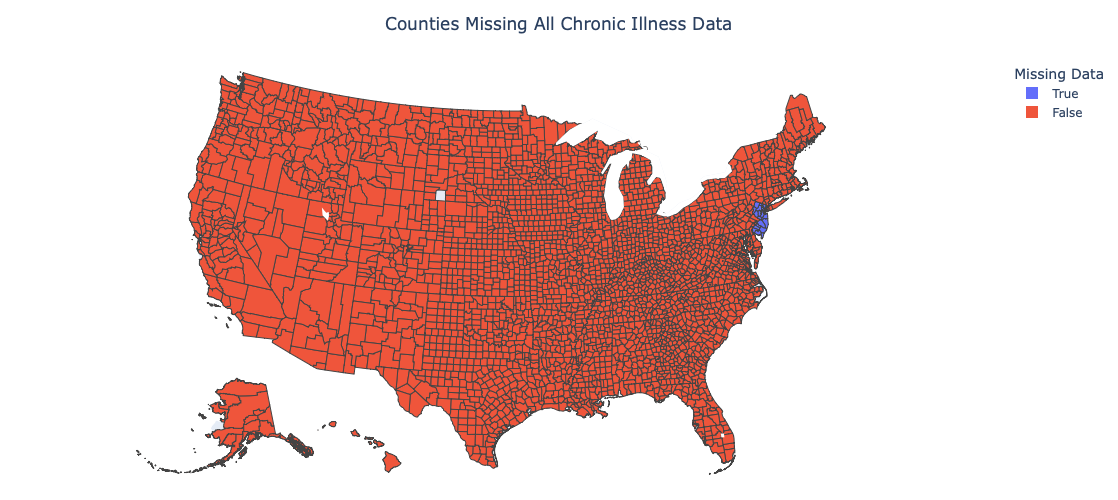

In [ ]:
# ensure FIPS is padded with 0s as needed
places["CountyFIPS"] = places["CountyFIPS"].astype(str).str.zfill(5)

# flag missing counties
places["missing_all_chronic"] = places[crude + ci].isnull().all(axis=1)

# color missing counties on map
fig = px.choropleth(
    places,
    geojson = "https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json",
    locations = "CountyFIPS",
    color = "missing_all_chronic",
    color_continuous_scale = ["#cccccc", "#ff0000"], 
    scope = "usa",
    labels = {"missing_all_chronic": "Missing Data"},
    title = "Counties Missing All Chronic Illness Data"
)

fig.update_layout(
    title_x = 0.5,
    width = 1000,
    height = 500, 
    margin = dict(l = 20, r = 20, t = 60, b =20)
)

fig.show()

### Mapping

Again, it appears the **Southeast** has higher chronic disease prevalence in its counties. 

In [ ]:
# general disease burden
places["Chronic_CrudePrev_Mean"] = places[crude].mean(axis = 1)

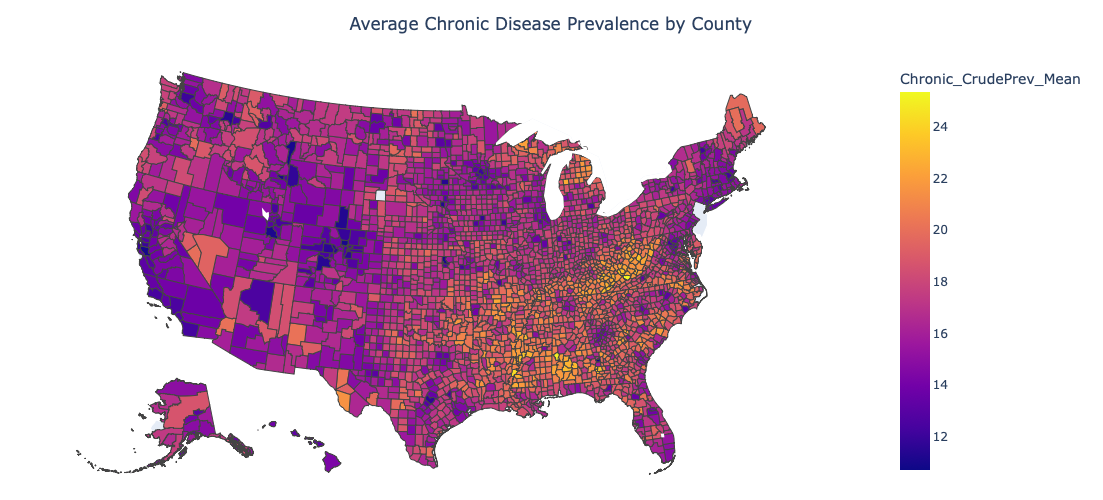

In [ ]:
fig = px.choropleth(
    places,
    geojson = "https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json",
    locations = 'CountyFIPS',
    color = 'Chronic_CrudePrev_Mean',
    scope = 'usa',
    labels = {"ChronicPrevalence_County": "Avg Chronic Disease Prevalence (%)"},
    title = "Average Chronic Disease Prevalence by County",
)

fig.update_layout(
    title_x = 0.5,
    width = 1000,
    height = 500, 
    margin=dict(l = 20, r = 20, t = 60, b = 20)
)

fig.show()

## <code style="background:lavender;color:black">MERGING THE DATA</code>

### Link 1

In [ ]:
# load food insecurity data
mmg = pd.read_excel('./data/raw/feeding_america/MMG2017_2015.xlsx')

# ensure FIPS is properly formatted
mmg['FIPS'] = mmg['FIPS'].astype(str).str.zfill(5)

In [ ]:
# load food desert data (2015)
atlas = pd.read_excel('./data/raw/usda_food_access/2015/FoodAccessResearchAtlasData2015.xlsx',
                     sheet_name = 2,
                     dtype = 'str')

# rename Hispanic subgroup to follow naming conventions
atlas = atlas.rename(columns = {'TractHispanic': 'TractHisp'})

# deriving county ID (FIPS)
atlas['StateFIPS'] = atlas['CensusTract'].str[:2]
atlas['CountyFIPS'] = atlas['CensusTract'].str[2:5]
atlas['FIPS'] = atlas['StateFIPS'] + atlas['CountyFIPS']

In [ ]:
# classifying columns by aggregation method

sum_cols = [
    'Urban','POP2010','OHU2010','GroupQuartersFlag','NUMGQTRS','LILATracts_1And10',
    'LILATracts_halfAnd10','LILATracts_1And20','LILATracts_Vehicle','HUNVFlag','LowIncomeTracts',
    'LAPOP1_10','LAPOP05_10','LAPOP1_20','LALOWI1_10','LALOWI05_10','LALOWI1_20',
    'lapophalf','lalowihalf','lakidshalf','laseniorshalf','lawhitehalf','lablackhalf','laasianhalf',
    'lanhopihalf','laaianhalf','laomultirhalf','lahisphalf','lahunvhalf','lasnaphalf',
    'lapop1','lalowi1','lakids1','laseniors1','lawhite1','lablack1','laasian1','lanhopi1',
    'laaian1','laomultir1','lahisp1','lahunv1','lasnap1',
    'lapop10','lalowi10','lakids10','laseniors10','lawhite10','lablack10','laasian10','lanhopi10',
    'laaian10','laomultir10','lahisp10','lahunv10','lasnap10',
    'lapop20','lalowi20','lakids20','laseniors20','lawhite20','lablack20','laasian20','lanhopi20',
    'laaian20','laomultir20','lahisp20','lahunv20','lasnap20',
    'TractLOWI','TractKids','TractSeniors','TractWhite','TractBlack','TractAsian','TractNHOPI',
    'TractAIAN','TractOMultir','TractHisp','TractHUNV','TractSNAP', 'LA1and10','LAhalfand10','LA1and20','LATracts_half','LATracts1',
    'LATracts10','LATracts20','LATractsVehicle_20',
]

share_pop_cols = [
    'PCTGQTRS','PovertyRate', 'lapophalfshare','lalowihalfshare','lakidshalfshare',
    'laseniorshalfshare','lawhitehalfshare','lablackhalfshare','laasianhalfshare','lanhopihalfshare',
    'laaianhalfshare','laomultirhalfshare','lahisphalfshare',
    'lapop1share','lalowi1share','lakids1share','laseniors1share','lawhite1share','lablack1share',
    'laasian1share','lanhopi1share','laaian1share','laomultir1share','lahisp1share',
    'lapop10share','lalowi10share','lakids10share','laseniors10share','lawhite10share',
    'lablack10share','laasian10share','lanhopi10share','laaian10share','laomultir10share','lahisp10share',
    'lapop20share','lalowi20share','lakids20share','laseniors20share',
    'lawhite20share','lablack20share','laasian20share','lanhopi20share','laaian20share','laomultir20share',
    'lahisp20share'
]

share_ohu_cols = [
    'lahunv20share', 'lahunv10share', 'lahunvhalfshare', 'lahunv1share',
    'lasnap20share', 'lasnap10share', 'lasnaphalfshare', 'lasnap1share'
]

mean_cols = ['MedianFamilyIncome']

# sum cols
county_sum = atlas.groupby('FIPS')[sum_cols].sum()

# total population weighted share columns
county_share = atlas[share_pop_cols + ['FIPS', 'POP2010']].copy()
for col in share_pop_cols:
    county_share[col] = county_share[col] * county_share['POP2010']

county_share = county_share.groupby('FIPS')[share_pop_cols].sum()
county_share = county_share.div(atlas.groupby('FIPS')['POP2010'].sum(), axis=0)

# OHU-weighted share columns 
county_ohu = atlas[share_ohu_cols + ['FIPS', 'OHU2010']].copy()
for col in share_ohu_cols:
    county_ohu[col] = county_ohu[col] * county_ohu['OHU2010']

county_ohu = county_ohu.groupby('FIPS')[share_ohu_cols].sum()
county_ohu = county_ohu.div(atlas.groupby('FIPS')['OHU2010'].sum(), axis=0)

# mean col
county_mean = atlas.groupby('FIPS')[mean_cols].mean()

# combine
county_atlas = pd.concat([county_sum, county_share, county_ohu, county_mean], axis=1).reset_index()

# sanity check
print(county_atlas.shape)
county_atlas.head()

(3143, 145)


,FIPS,Urban,POP2010,OHU2010,GroupQuartersFlag,NUMGQTRS,LILATracts_1And10,LILATracts_halfAnd10,LILATracts_1And20,LILATracts_Vehicle,HUNVFlag,LowIncomeTracts,LAPOP1_10,LAPOP05_10,LAPOP1_20,LALOWI1_10,LALOWI05_10,LALOWI1_20,lapophalf,lalowihalf,lakidshalf,laseniorshalf,lawhitehalf,lablackhalf,laasianhalf,lanhopihalf,laaianhalf,laomultirhalf,lahisphalf,lahunvhalf,lasnaphalf,lapop1,lalowi1,lakids1,laseniors1,lawhite1,lablack1,laasian1,lanhopi1,laaian1,laomultir1,lahisp1,lahunv1,lasnap1,lapop10,lalowi10,lakids10,laseniors10,lawhite10,lablack10,laasian10,lanhopi10,laaian10,laomultir10,lahisp10,lahunv10,lasnap10,lapop20,lalowi20,lakids20,laseniors20,lawhite20,lablack20,laasian20,lanhopi20,laaian20,laomultir20,lahisp20,lahunv20,lasnap20,TractLOWI,TractKids,TractSeniors,TractWhite,TractBlack,TractAsian,TractNHOPI,TractAIAN,TractOMultir,TractHisp,TractHUNV,TractSNAP,LA1and10,LAhalfand10,LA1and20,LATracts_half,LATracts1,LATracts10,LATracts20,LATractsVehicle_20,PCTGQTRS,PovertyRate,lapophalfshare,lalowihalfshare,lakidshalfshare,laseniorshalfshare,lawhitehalfshare,lablackhalfshare,laasianhalfshare,lanhopihalfshare,laaianhalfshare,laomultirhalfshare,lahisphalfshare,lapop1share,lalowi1share,lakids1share,laseniors1share,lawhite1share,lablack1share,laasian1share,lanhopi1share,laaian1share,laomultir1share,lahisp1share,lapop10share,lalowi10share,lakids10share,laseniors10share,lawhite10share,lablack10share,laasian10share,lanhopi10share,laaian10share,laomultir10share,lahisp10share,lapop20share,lalowi20share,lakids20share,laseniors20share,lawhite20share,lablack20share,laasian20share,lanhopi20share,laaian20share,laomultir20share,lahisp20share,lahunv20share,lahunv10share,lahunvhalfshare,lahunv1share,lasnap20share,lasnap10share,lasnaphalfshare,lasnap1share,MedianFamilyIncome
0,01001,7,54571,20221,0,455,2,2,1,2,4,2,18092.661348,30141.638549,11064.872922,6835.642497,10632.847467,3939.647420,48518.850095,16697.024438,13081.201969,5818.638953,38073.441804,8657.267416,370.606503,22.612647,214.568901,1180.352908,1135.959910,909.452242,2363.371538,36469.872893,12899.819468,9721.503804,4245.641526,28592.192359,6645.162299,188.457143,15.711041,161.635647,866.714452,790.187847,677.672769,1822.537716,7027.788426,2895.995077,1756.890864,892.652772,4393.008163,2469.136382,7.278660,3.000000,27.006332,128.358891,107.655737,167.556997,487.883613,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18692,14613,6546,42855,9643,474,32,232,1335,1310,1081,2682,9,10,6,7,6,3,0,4,0.008338,12.807222,0.889096,0.305969,0.239710,0.106625,0.697686,0.158642,0.006791,0.000414,0.003932,0.021630,0.020816,0.668301,0.236386,0.178144,0.077800,0.523945,0.121771,0.003453,0.000288,0.002962,0.015882,0.014480,0.128782,0.053068,0.032195,0.016358,0.080501,0.045246,0.000133,5.497425e-05,0.000495,0.002352,0.001973,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.008286,0.044976,0.033513,0.0,0.024128,0.116877,0.090131,61082.916667
1,01003,14,182265,73180,0,2307,3,3,3,2,4,7,46400.350641,72307.849152,43486.806226,15459.848416,23336.898273,14323.851047,165014.094039,54597.720787,38114.129728,27128.730996,142031.938468,14915.241889,1157.088823,82.463708,1130.367880,5696.993209,7236.577106,1869.987504,5953.358706,131649.158741,44343.516539,30468.848829,21633.863019,114569.054526,10709.565455,792.906323,51.305996,971.615628,4554.710751,5400.587834,1394.162766,4874.837779,2913.544415,1135.997370,629.217431,511.573835,2419.672999,393.187000,7.278226,0.000000,43.169282,50.236909,20.732590,43.197231,102.155983,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,63277,41898,30568,156153,17105,1348,89,1216,6354,7992,2242,6471,15,16,13,14,13,2,0,4,0.012657,13.819480,0.905353,0.299551,0.209114,0.148842,0.779261,0.081833,0.006348,0.000452,0.006202,0.031257,0.039704,0.722295,0.243291,0.167168,0.118695,0.628585,0.058758,0.004350,0.000281,0.005331,0.024989,0.029630,0.015985,0.006233,0.003452,0.002807,0.013276,0.002157,0.000040,0.000000e+00,0.000237,0.000276,0.000114,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [ ]:
# merge
link1 = pd.merge(mmg, county_atlas, on = 'FIPS', how = 'inner')

# verify
print(link1.shape)
link1.head()

In [ ]:
# save processed datasets
county_atlas.to_csv('./data/processed/link1/atlas_2015.csv', index = False)
mmg.to_csv('./data/processed/link1/mmg_2015.csv', index = False)
link1.to_csv('./data/processed/link1/link1.csv', index = False)

### Link 2

In [ ]:
# load PLACES data 
places = pd.read_csv('./data/raw/cdc_health/PLACES__County_Data_(GIS_Friendly_Format),_2021_release_20251027.csv')

# formatting FIPS
places["FIPS"] = places["CountyFIPS"].astype(str).str.zfill(5)

# general disease burden
places["Chronic_CrudePrev_Mean"] = places[crude].mean(axis = 1)

In [ ]:
# load food desert data (2019)
atlas = pd.read_csv('./data/raw/usda_food_access/2019/Food_Access_Research_Atlas.csv')

# rename Hispanic subgroup to follow naming conventions
atlas = atlas.rename(columns = {'TractHispanic': 'TractHisp'})

# deriving county ID (FIPS)
atlas['CensusTract'] = atlas['CensusTract'].astype(str).str.zfill(11)
atlas['StateFIPS'] = atlas['CensusTract'].str[:2]
atlas['CountyFIPS'] = atlas['CensusTract'].str[2:5]
atlas['FIPS'] = atlas['StateFIPS'] + atlas['CountyFIPS']

In [ ]:
# classifying columns by aggregation method

sum_cols = [
    'Urban','Pop2010','OHU2010','GroupQuartersFlag','NUMGQTRS','LILATracts_1And10',
    'LILATracts_halfAnd10','LILATracts_1And20','LILATracts_Vehicle','HUNVFlag','LowIncomeTracts',
    'LAPOP1_10','LAPOP05_10','LAPOP1_20','LALOWI1_10','LALOWI05_10','LALOWI1_20',
    'lapophalf','lalowihalf','lakidshalf','laseniorshalf','lawhitehalf','lablackhalf','laasianhalf',
    'lanhopihalf','laaianhalf','laomultirhalf','lahisphalf','lahunvhalf','lasnaphalf',
    'lapop1','lalowi1','lakids1','laseniors1','lawhite1','lablack1','laasian1','lanhopi1',
    'laaian1','laomultir1','lahisp1','lahunv1','lasnap1',
    'lapop10','lalowi10','lakids10','laseniors10','lawhite10','lablack10','laasian10','lanhopi10',
    'laaian10','laomultir10','lahisp10','lahunv10','lasnap10',
    'lapop20','lalowi20','lakids20','laseniors20','lawhite20','lablack20','laasian20','lanhopi20',
    'laaian20','laomultir20','lahisp20','lahunv20','lasnap20',
    'TractLOWI','TractKids','TractSeniors','TractWhite','TractBlack','TractAsian','TractNHOPI',
    'TractAIAN','TractOMultir','TractHisp','TractHUNV','TractSNAP', 'LA1and10','LAhalfand10','LA1and20','LATracts_half','LATracts1',
    'LATracts10','LATracts20','LATractsVehicle_20',
]

share_pop_cols = [
    'PCTGQTRS','PovertyRate', 'lapophalfshare','lalowihalfshare','lakidshalfshare',
    'laseniorshalfshare','lawhitehalfshare','lablackhalfshare','laasianhalfshare','lanhopihalfshare',
    'laaianhalfshare','laomultirhalfshare','lahisphalfshare',
    'lapop1share','lalowi1share','lakids1share','laseniors1share','lawhite1share','lablack1share',
    'laasian1share','lanhopi1share','laaian1share','laomultir1share','lahisp1share',
    'lapop10share','lalowi10share','lakids10share','laseniors10share','lawhite10share',
    'lablack10share','laasian10share','lanhopi10share','laaian10share','laomultir10share','lahisp10share',
    'lapop20share','lalowi20share','lakids20share','laseniors20share',
    'lawhite20share','lablack20share','laasian20share','lanhopi20share','laaian20share','laomultir20share',
    'lahisp20share'
]

share_ohu_cols = [
    'lahunv20share', 'lahunv10share', 'lahunvhalfshare', 'lahunv1share',
    'lasnap20share', 'lasnap10share', 'lasnaphalfshare', 'lasnap1share'
]

mean_cols = ['MedianFamilyIncome']

# sum cols
county_sum = atlas.groupby('FIPS')[sum_cols].sum()

# total population weighted share columns
county_share = atlas[share_pop_cols + ['FIPS', 'Pop2010']].copy()
for col in share_pop_cols:
    county_share[col] = county_share[col] * county_share['Pop2010']

county_share = county_share.groupby('FIPS')[share_pop_cols].sum()
county_share = county_share.div(atlas.groupby('FIPS')['Pop2010'].sum(), axis=0)

# OHU-weighted share columns 
county_ohu = atlas[share_ohu_cols + ['FIPS', 'OHU2010']].copy()
for col in share_ohu_cols:
    county_ohu[col] = county_ohu[col] * county_ohu['OHU2010']

county_ohu = county_ohu.groupby('FIPS')[share_ohu_cols].sum()
county_ohu = county_ohu.div(atlas.groupby('FIPS')['OHU2010'].sum(), axis=0)

# mean col
county_mean = atlas.groupby('FIPS')[mean_cols].mean()

# combine
county_atlas = pd.concat([county_sum, county_share, county_ohu, county_mean], axis = 1).reset_index()

# sanity check
print(county_atlas.shape)
county_atlas.head()

(3142, 145)


,FIPS,Urban,Pop2010,OHU2010,GroupQuartersFlag,NUMGQTRS,LILATracts_1And10,LILATracts_halfAnd10,LILATracts_1And20,LILATracts_Vehicle,HUNVFlag,LowIncomeTracts,LAPOP1_10,LAPOP05_10,LAPOP1_20,LALOWI1_10,LALOWI05_10,LALOWI1_20,lapophalf,lalowihalf,lakidshalf,laseniorshalf,lawhitehalf,lablackhalf,laasianhalf,lanhopihalf,laaianhalf,laomultirhalf,lahisphalf,lahunvhalf,lasnaphalf,lapop1,lalowi1,lakids1,laseniors1,lawhite1,lablack1,laasian1,lanhopi1,laaian1,laomultir1,lahisp1,lahunv1,lasnap1,lapop10,lalowi10,lakids10,laseniors10,lawhite10,lablack10,laasian10,lanhopi10,laaian10,laomultir10,lahisp10,lahunv10,lasnap10,lapop20,lalowi20,lakids20,laseniors20,lawhite20,lablack20,laasian20,lanhopi20,laaian20,laomultir20,lahisp20,lahunv20,lasnap20,TractLOWI,TractKids,TractSeniors,TractWhite,TractBlack,TractAsian,TractNHOPI,TractAIAN,TractOMultir,TractHisp,TractHUNV,TractSNAP,LA1and10,LAhalfand10,LA1and20,LATracts_half,LATracts1,LATracts10,LATracts20,LATractsVehicle_20,PCTGQTRS,PovertyRate,lapophalfshare,lalowihalfshare,lakidshalfshare,laseniorshalfshare,lawhitehalfshare,lablackhalfshare,laasianhalfshare,lanhopihalfshare,laaianhalfshare,laomultirhalfshare,lahisphalfshare,lapop1share,lalowi1share,lakids1share,laseniors1share,lawhite1share,lablack1share,laasian1share,lanhopi1share,laaian1share,laomultir1share,lahisp1share,lapop10share,lalowi10share,lakids10share,laseniors10share,lawhite10share,lablack10share,laasian10share,lanhopi10share,laaian10share,laomultir10share,lahisp10share,lapop20share,lalowi20share,lakids20share,laseniors20share,lawhite20share,lablack20share,laasian20share,lanhopi20share,laaian20share,laomultir20share,lahisp20share,lahunv20share,lahunv10share,lahunvhalfshare,lahunv1share,lasnap20share,lasnap10share,lasnaphalfshare,lasnap1share,MedianFamilyIncome
0,01001,7,54571,20221,0,455.0,5,5,3,1,3,5,18503.0,29442.0,13384.0,7106.0,10300.0,4799.0,49497.0,15518.0,13281.0,5935.0,38699.0,8987.0,374.0,23.0,216.0,1200.0,1166.0,1045.0,2338.0,37424.0,12067.0,9973.0,4393.0,28864.0,7295.0,176.0,16.0,171.0,901.0,800.0,834.0,1827.0,5119.0,2307.0,1199.0,707.0,2951.0,2054.0,4.0,0.0,21.0,88.0,67.0,222.0,313.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,17243.0,14613.0,6546.0,42855.0,9643.0,474.0,32.0,232.0,1335.0,1310.0,1191.0,2692.0,9,9,7,7,7,2,0,3,0.834086,15.137584,90.705437,28.436537,24.336182,10.873803,70.916389,16.469490,0.683246,0.042440,0.394810,2.197971,2.136426,68.578638,22.116228,18.273725,8.047010,52.892025,13.370233,0.323515,0.030831,0.314370,1.650043,1.466506,9.380261,4.225003,2.197115,1.296713,5.408136,3.762983,0.007128,0.000000,0.039432,0.162581,0.121978,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.098369,5.162921,4.121604,0.0,1.553792,11.566841,9.039187,69337.500000
1,01003,14,182265,73180,0,2307.0,4,4,3,3,6,7,45789.0,71643.0,43481.0,14468.0,22146.0,13622.0,165616.0,48117.0,38278.0,27241.0,142534.0,14958.0,1155.0,83.0,1135.0,5757.0,7321.0,2178.0,5032.0,132442.0,38848.0,30633.0,21828.0,115294.0,10622.0,807.0,51.0,974.0,4695.0,5695.0,1653.0,4027.0,2308.0,846.0,516.0,390.0,1850.0,385.0,4.0,0.0,36.0,34.0,17.0,32.0,78.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,57843.0,41898.0,30568.0,156153.0,17105.0,1348.0,89.0,1216.0,6354.0,7992.0,2705.0,5926.0,14,15,13,14,13,1,0,6,1.265261,10.947872,90.868054,26.398817,21.002295,14.946627,78.202305,8.205963,0.634644,0.044702,0.621834,3.159565,4.015459,72.664094,21.311019,16.806787,11.975907,63.257203,5.827210,0.443795,0.028281,0.533546,2.575929,3.124749,1.266195,0.463851,0.283696,0.214160,1.015398,0.210735,0.002002,0.000000,0.019729,0.018491,0.009183,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.043727,2.977356,2.262375,0.0,0.105335,6.875931,5.506560,72665.741935
2,01005,2,27457,9820,0,3193.0,4,5,1,3,3,8,5636.0,8563.0,993.0,2864.0,4452.0,424.0,23762.0,11901.0,4943.0,3348.0,11829.0,10675.0,74.0,29.0,109.0,1047.0,1272.0,742.0,2236.0,19007.0,9290.0,3701.0,2537.0,9800.0,8138.0,66.0,12.0,101.0,889.0,1044.0,545.0,1648.0,4643.0,2440.0,791.0,629.0,1942.0,2275.0,10.0,3.0,12.0,400.0,42

In [ ]:
# merge
link2 = pd.merge(places, county_atlas, on = 'FIPS', how = 'inner')

# verify
print(link2.shape)
link2.head()

(3142, 272)


,StateAbbr,StateDesc,CountyName,CountyFIPS,TotalPopulation,ACCESS2_CrudePrev,ACCESS2_Crude95CI,ACCESS2_AdjPrev,ACCESS2_Adj95CI,ARTHRITIS_CrudePrev,ARTHRITIS_Crude95CI,ARTHRITIS_AdjPrev,ARTHRITIS_Adj95CI,BINGE_CrudePrev,BINGE_Crude95CI,BINGE_AdjPrev,BINGE_Adj95CI,BPHIGH_CrudePrev,BPHIGH_Crude95CI,BPHIGH_AdjPrev,BPHIGH_Adj95CI,BPMED_CrudePrev,BPMED_Crude95CI,BPMED_AdjPrev,BPMED_Adj95CI,CANCER_CrudePrev,CANCER_Crude95CI,CANCER_AdjPrev,CANCER_Adj95CI,CASTHMA_CrudePrev,CASTHMA_Crude95CI,CASTHMA_AdjPrev,CASTHMA_Adj95CI,CERVICAL_CrudePrev,CERVICAL_Crude95CI,CERVICAL_AdjPrev,CERVICAL_Adj95CI,CHD_CrudePrev,CHD_Crude95CI,CHD_AdjPrev,CHD_Adj95CI,CHECKUP_CrudePrev,CHECKUP_Crude95CI,CHECKUP_AdjPrev,CHECKUP_Adj95CI,CHOLSCREEN_CrudePrev,CHOLSCREEN_Crude95CI,CHOLSCREEN_AdjPrev,CHOLSCREEN_Adj95CI,COLON_SCREEN_CrudePrev,COLON_SCREEN_Crude95CI,COLON_SCREEN_AdjPrev,COLON_SCREEN_Adj95CI,COPD_CrudePrev,COPD_Crude95CI,COPD_AdjPrev,COPD_Adj95CI,COREM_CrudePrev,COREM_Crude95CI,COREM_AdjPrev,COREM_Adj95CI,COREW_CrudePrev,COREW_Crude95CI,COREW_AdjPrev,COREW_Adj95CI,CSMOKING_CrudePrev,CSMOKING_Crude95CI,CSMOKING_AdjPrev,CSMOKING_Adj95CI,DENTAL_CrudePrev,DENTAL_Crude95CI,DENTAL_AdjPrev,DENTAL_Adj95CI,DEPRESSION_CrudePrev,DEPRESSION_Crude95CI,DEPRESSION_AdjPrev,DEPRESSION_Adj95CI,DIABETES_CrudePrev,DIABETES_Crude95CI,DIABETES_AdjPrev,DIABETES_Adj95CI,GHLTH_CrudePrev,GHLTH_Crude95CI,GHLTH_AdjPrev,GHLTH_Adj95CI,HIGHCHOL_CrudePrev,HIGHCHOL_Crude95CI,HIGHCHOL_AdjPrev,HIGHCHOL_Adj95CI,KIDNEY_CrudePrev,KIDNEY_Crude95CI,KIDNEY_AdjPrev,KIDNEY_Adj95CI,LPA_CrudePrev,LPA_Crude95CI,LPA_AdjPrev,LPA_Adj95CI,MAMMOUSE_CrudePrev,MAMMOUSE_Crude95CI,MAMMOUSE_AdjPrev,MAMMOUSE_Adj95CI,MHLTH_CrudePrev,MHLTH_Crude95CI,MHLTH_AdjPrev,MHLTH_Adj95CI,OBESITY_CrudePrev,OBESITY_Crude95CI,OBESITY_AdjPrev,OBESITY_Adj95CI,PHLTH_CrudePrev,PHLTH_Crude95CI,PHLTH_AdjPrev,PHLTH_Adj95CI,SLEEP_CrudePrev,SLEEP_Crude95CI,SLEEP_AdjPrev,SLEEP_Adj95CI,STROKE_CrudePrev,STROKE_Crude95CI,STROKE_AdjPrev,STROKE_Adj95CI,TEETHLOST_CrudePrev,TEETHLOST_Crude95CI,TEETHLOST_AdjPrev,TEETHLOST_Adj95CI,Geolocation,FIPS,Chronic_CrudePrev_Mean,Urban,Pop2010,OHU2010,GroupQuartersFlag,NUMGQTRS,LILATracts_1And10,LILATracts_halfAnd10,LILATracts_1And20,LILATracts_Vehicle,HUNVFlag,LowIncomeTracts,LAPOP1_10,LAPOP05_10,LAPOP1_20,LALOWI1_10,LALOWI05_10,LALOWI1_20,lapophalf,lalowihalf,lakidshalf,laseniorshalf,lawhitehalf,lablackhalf,laasianhalf,lanhopihalf,laaianhalf,laomultirhalf,lahisphalf,lahunvhalf,lasnaphalf,lapop1,lalowi1,lakids1,laseniors1,lawhite1,lablack1,laasian1,lanhopi1,laaian1,laomultir1,lahisp1,lahunv1,lasnap1,lapop10,lalowi10,lakids10,laseniors10,lawhite10,lablack10,laasian10,lanhopi10,laaian10,laomultir10,lahisp10,lahunv10,lasnap10,lapop20,lalowi20,lakids20,laseniors20,lawhite20,lablack20,laasian20,lanhopi20,laaian20,laomultir20,lahisp20,lahunv20,lasnap20,TractLOWI,TractKids,TractSeniors,TractWhite,TractBlack,TractAsian,TractNHOPI,TractAIAN,TractOMultir,TractHisp,TractHUNV,TractSNAP,LA1and10,LAhalfand10,LA1and20,LATracts_half,LATracts1,LATracts10,LATracts20,LATractsVehicle_20,PCTGQTRS,PovertyRate,lapophalfshare,lalowihalfshare,lakidshalfshare,laseniorshalfshare,lawhitehalfshare,lablackhalfshare,laasianhalfshare,lanhopihalfshare,laaianhalfshare,laomultirhalfshare,lahisphalfshare,lapop1share,lalowi1share,lakids1share,laseniors1share,lawhite1share,lablack1share,laasian1share,lanhopi1share,laaian1share,laomultir1share,lahisp1share,lapop10share,lalowi10share,lakids10share,laseniors10share,lawhite10share,lablack10share,laasian10share,lanhopi10share,laaian10share,laomultir10share,lahisp10share,lapop20share,lalowi20share,lakids20share,laseniors20share,lawhite20share,lablack20share,laasian20share,lanhopi20share,laaian20share,laomultir20share,lahisp20share,lahunv20share,lahunv10share,lahunvhalfshare,lahunv1share,lasnap20share,lasnap10share,lasnaphalfshare,lasnap1share,MedianFamilyIncome
0,NJ,New Jersey,Warren,34041,"105,267",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

In [ ]:
# save processed datasets
county_atlas.to_csv('./data/processed/link2/atlas_2019.csv', index = False)
places.to_csv('./data/processed/link2/places_2021.csv', index = False)
link2.to_csv('./data/processed/link2/link2.csv', index = False)

# 2. Heatmaps

This section recreates the county-level heatmaps and adds several new stratified visualizations. It:
- Loads raw data from Feeding America (MMG), USDA Food Access Research Atlas, and CDC PLACES
- Processes data to the county level using FIPS codes
- Generates nine county-level choropleth heatmaps using Plotly Express.

In [ ]:
COUNTY_GEOJSON_URL = "https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json"

## 1. Feeding America (MMG) — Food Insecurity Data

In [ ]:
# Load Feeding America Map the Meal Gap data (2015)
mmg = pd.read_excel('./data/raw/feeding_america/MMG2017_2015.xlsx')

# Ensure FIPS is a 5-character string
mmg['FIPS'] = mmg['FIPS'].astype(str).str.zfill(5)

mmg.head()

,FIPS,State,"County, State",2015 Food Insecurity Rate,# of Food Insecure Persons in 2015,Low Threshold in state,Low Threshold Type,High Threshold in state,High Threshold Type,% FI ≤ Low Threshold,% FI Btwn Thresholds,% FI > High Threshold,2015 Child food insecurity rate,# of Food Insecure Children in 2015,% food insecure children in HH w/ HH incomes below 185 FPL in 2015,% food insecure children in HH w/ HH incomes above 185 FPL in 2015,2015 Cost Per Meal,2015 Weighted Annual Food Budget Shortfall
0,01001,AL,"Autauga County, Alabama",0.139,7680,1.3,SNAP,1.85,Other Nutrition Program,0.472,0.221,0.307,0.210,2950,0.73,0.27,3.18,4376000
1,01003,AL,"Baldwin County, Alabama",0.130,25350,1.3,SNAP,1.85,Other Nutrition Program,0.526,0.168,0.306,0.220,9620,0.72,0.28,3.40,15466000
2,01005,AL,"Barbour County, Alabama",0.234,6290,1.3,SNAP,1.85,Other Nutrition Program,0.556,0.236,0.208,0.296,1700,0.80,0.20,3.05,3442000
3,01007,AL,"Bibb County, Alabama",0.161,3650,1.3,SNAP,1.85,Other Nutrition Program,0.538,0.256,0.206,0.250,1230,0.98,0.02,2.89,1888000
4,01009,AL,"Blount County, Alabama",0.113,6510,1.3,SNAP,1.85,Other Nutrition Program,0.640,0.175,0.186,0.239,3260,0.75,0.25,3.02,3528000


## 2. USDA Food Access Research Atlas — Food Access & Demographic Data

In [ ]:
## 2. USDA Food Access Research Atlas — Food Access & Demographic Data (2015)

# Load USDA 2015 Atlas dataset (Excel)
atlas = pd.read_excel('./data/raw/usda_food_access/FoodAccessResearchAtlasData2015.xlsx',
                     sheet_name = 2,
                     dtype = 'str')

# Ensure Census Tract column is string and 11 digits
atlas['CensusTract'] = atlas['CensusTract'].astype(str).str.zfill(11)

# Derive county-level FIPS: first 2 digits = state, next 3 digits = county
atlas['StateFIPS'] = atlas['CensusTract'].str[:2]
atlas['CountyFIPS'] = atlas['CensusTract'].str[2:5]
atlas['FIPS'] = atlas['StateFIPS'] + atlas['CountyFIPS']
numeric_cols = [
    'POP2010',
    'lapop1',
    'lalowi1',
    'lakids1',
    'laseniors1',
    'TractKids',
    'TractSeniors'
]

for col in numeric_cols:
    if col in atlas.columns:
        atlas[col] = pd.to_numeric(atlas[col], errors='coerce')

# Now aggregate USDA variables to county level
county_metrics = atlas.groupby('FIPS').agg(
    pop2010=('POP2010', 'sum'),

    # general low-access population (1 mile urban / 10 mile rural)
    la_pop=('lapop1', 'sum'),

    # low-income + low-access population
    la_low_income=('lalowi1', 'sum'),

    # children and senior low-access counts
    kids_low_access=('lakids1', 'sum'),
    total_kids=('TractKids', 'sum'),

    seniors_low_access=('laseniors1', 'sum'),
    total_seniors=('TractSeniors', 'sum')
).reset_index()

# Derived percentages (now safe)
county_metrics['pct_low_access'] = county_metrics['la_pop'] / county_metrics['pop2010']
county_metrics['pct_low_income_low_access'] = county_metrics['la_low_income'] / county_metrics['pop2010']

county_metrics['pct_kids_low_access'] = np.where(
    county_metrics['total_kids'] > 0,
    county_metrics['kids_low_access'] / county_metrics['total_kids'],
    np.nan
)

county_metrics['pct_seniors_low_access'] = np.where(
    county_metrics['total_seniors'] > 0,
    county_metrics['seniors_low_access'] / county_metrics['total_seniors'],
    np.nan
)

county_metrics.head()

,FIPS,pop2010,la_pop,la_low_income,kids_low_access,total_kids,seniors_low_access,total_seniors,pct_low_access,pct_low_income_low_access,pct_kids_low_access,pct_seniors_low_access
0,01001,54571,36469.872893,12899.819468,9721.503804,14613,4245.641526,6546,0.668301,0.236386,0.665264,0.648586
1,01003,182265,131649.158741,44343.516539,30468.848829,41898,21633.863019,30568,0.722295,0.243291,0.727215,0.707729
2,01005,27457,19197.262383,9721.108548,3752.692700,6015,2560.043174,3909,0.699176,0.354048,0.623889,0.654910
3,01007,22915,18918.377818,8937.631915,4252.431906,5201,2286.891978,2906,0.825589,0.390034,0.817618,0.786955
4,01009,57322,52242.222280,20568.194561,12930.509997,14106,7301.222109,8439,0.911382,0.358819,0.916667,0.865176


In [ ]:
# Aggregate tract-level Atlas data to county level for key metrics
county_metrics = atlas.groupby('FIPS').agg(
    pop2010=('POP2010', 'sum'),
    la_pop=('lapop1', 'sum'),              # low-access population (1 mile / 10 miles threshold)
    la_low_income=('lalowi1', 'sum'),      # low-income & low-access population
    kids_low_access=('lakids1', 'sum'),
    total_kids=('TractKids', 'sum'),
    seniors_low_access=('laseniors1', 'sum'),
    total_seniors=('TractSeniors', 'sum')
).reset_index()

# Percentage of population with low access to food (generic, any income)
county_metrics['pct_low_access'] = county_metrics['la_pop'] / county_metrics['pop2010']

# Percentage of population that is both low-income and low-access ("food desert" proxy)
county_metrics['pct_low_income_low_access'] = county_metrics['la_low_income'] / county_metrics['pop2010']

# Child and senior low-access percentages (handle division by zero)
county_metrics['pct_kids_low_access'] = np.where(
    county_metrics['total_kids'] > 0,
    county_metrics['kids_low_access'] / county_metrics['total_kids'],
    np.nan,
)
county_metrics['pct_seniors_low_access'] = np.where(
    county_metrics['total_seniors'] > 0,
    county_metrics['seniors_low_access'] / county_metrics['total_seniors'],
    np.nan,
)

county_metrics.head()

,FIPS,pop2010,la_pop,la_low_income,kids_low_access,total_kids,seniors_low_access,total_seniors,pct_low_access,pct_low_income_low_access,pct_kids_low_access,pct_seniors_low_access
0,01001,54571,36469.872893,12899.819468,9721.503804,14613,4245.641526,6546,0.668301,0.236386,0.665264,0.648586
1,01003,182265,131649.158741,44343.516539,30468.848829,41898,21633.863019,30568,0.722295,0.243291,0.727215,0.707729
2,01005,27457,19197.262383,9721.108548,3752.692700,6015,2560.043174,3909,0.699176,0.354048,0.623889,0.654910
3,01007,22915,18918.377818,8937.631915,4252.431906,5201,2286.891978,2906,0.825589,0.390034,0.817618,0.786955
4,01009,57322,52242.222280,20568.194561,12930.509997,14106,7301.222109,8439,0.911382,0.358819,0.916667,0.865176


## 3. CDC PLACES — Chronic Disease Outcomes

In [ ]:
# Load CDC PLACES county-level data (2020 release)
places = pd.read_csv('./data/raw/cdc_health/PLACES__County_Data_(GIS_Friendly_Format),_2020_release_20251027.csv')

# Create 5-digit FIPS string
places['FIPS'] = places['CountyFIPS'].astype(str).str.zfill(5)

# Chronic illness measures to average
chronic = ['ARTHRITIS', 'BPHIGH', 'CANCER', 'CASTHMA',
           'CHD', 'COPD', 'DIABETES', 'HIGHCHOL',
           'KIDNEY', 'STROKE', 'OBESITY']
crude_cols = [f"{m}_CrudePrev" for m in chronic]

# Average crude prevalence across major chronic diseases
places['Chronic_CrudePrev_Mean'] = places[crude_cols].mean(axis=1)

places[['FIPS', 'Chronic_CrudePrev_Mean']].head()

,FIPS,Chronic_CrudePrev_Mean
0,01001,18.072727
1,01003,17.754545
2,01005,22.027273
3,01007,19.309091
4,01009,19.181818


## 4. County-Level Choropleth Heatmaps

### 4.1 Heatmap 1 — % of County Population in a Food Desert

In [ ]:
fig = px.choropleth(
    county_metrics,
    geojson=COUNTY_GEOJSON_URL,
    locations='FIPS',
    color='pct_low_income_low_access',
    range_color=(county_metrics['pct_low_income_low_access'].min(),
                 county_metrics['pct_low_income_low_access'].max()),
    scope='usa',
    labels={'pct_low_income_low_access': '% Food Desert Pop'},
    color_continuous_scale=px.colors.sequential.Magma
)

fig.update_layout(
    title_text='% of County Population in a Food Desert',
    title_x=0.5,
    width=1000,
    height=500,
    margin=dict(l=20, r=20, t=60, b=20)
)
fig.show()

### 4.2 Heatmap 2 — Food Insecurity Rate by County (2015)

In [ ]:
fig = px.choropleth(
    mmg,
    geojson=COUNTY_GEOJSON_URL,
    locations='FIPS',
    color='2015 Food Insecurity Rate',
    scope='usa',
    labels={'2015 Food Insecurity Rate': 'Food Insecurity Rate'},
    title='Food Insecurity Rate by County (2015)'
)

fig.update_layout(
    title_x=0.5,
    width=1000,
    height=500,
    margin=dict(l=20, r=20, t=60, b=20)
)
fig.show()

### 4.3 Heatmap 3 — Average Chronic Disease Prevalence by County

In [ ]:
fig = px.choropleth(
    places,
    geojson=COUNTY_GEOJSON_URL,
    locations='FIPS',
    color='Chronic_CrudePrev_Mean',
    scope='usa',
    labels={'Chronic_CrudePrev_Mean': 'Avg Chronic Disease Prevalence (%)'},
    title='Average Chronic Disease Prevalence by County'
)

fig.update_layout(
    title_x=0.5,
    width=1000,
    height=500,
    margin=dict(l=20, r=20, t=60, b=20)
)
fig.show()

### 4.4 Heatmap 4 — % of County Population with Low Food Access

In [ ]:
fig = px.choropleth(
    county_metrics,
    geojson=COUNTY_GEOJSON_URL,
    locations='FIPS',
    color='pct_low_access',
    range_color=(county_metrics['pct_low_access'].min(),
                 county_metrics['pct_low_access'].max()),
    scope='usa',
    labels={'pct_low_access': '% Low Access Pop'},
    color_continuous_scale=px.colors.sequential.Turbo[::-1]
)

fig.update_layout(
    title_text='% of County Population with Low Access to Food (1 mile threshold)',
    title_x=0.5,
    width=1000,
    height=500,
    margin=dict(l=20, r=20, t=60, b=20)
)
fig.show()

### 4.5 Heatmap 5 — Child Food Insecurity Rate by County

In [ ]:
fig = px.choropleth(
    mmg,
    geojson=COUNTY_GEOJSON_URL,
    locations='FIPS',
    color='2015 Child food insecurity rate',
    scope='usa',
    labels={'2015 Child food insecurity rate': 'Child Food Insecurity Rate'},
    title='Child Food Insecurity Rate by County (2015)'
)

fig.update_layout(
    title_x=0.5,
    width=1000,
    height=500,
    margin=dict(l=20, r=20, t=60, b=20)
)
fig.show()

### 4.6 Heatmap 6 — % of Food Insecure Children in Low-Income Households

In [ ]:
col_name = '% food insecure children in HH w/ HH incomes below 185 FPL in 2015'
fig = px.choropleth(
    mmg,
    geojson=COUNTY_GEOJSON_URL,
    locations='FIPS',
    color=col_name,
    scope='usa',
    labels={col_name: '% FI Children in <185% FPL HHs'},
    title='% of Food Insecure Children in Households <185% FPL (2015)'
)

fig.update_layout(
    title_x=0.5,
    width=1000,
    height=500,
    margin=dict(l=20, r=20, t=60, b=20)
)
fig.show()

### 4.7 Heatmap 7 — % of Children Living in Low-Access Areas

In [ ]:
fig = px.choropleth(
    county_metrics,
    geojson=COUNTY_GEOJSON_URL,
    locations='FIPS',
    color='pct_kids_low_access',
    scope='usa',
    labels={'pct_kids_low_access': '% Children Low Access'},
    title='% of Children Living in Low-Access Food Areas (1 mile threshold)'
)

fig.update_layout(
    title_x=0.5,
    width=1000,
    height=500,
    margin=dict(l=20, r=20, t=60, b=20)
)
fig.show()

### 4.8 Heatmap 8 — % of Seniors Living in Low-Access Areas

In [ ]:
fig = px.choropleth(
    county_metrics,
    geojson=COUNTY_GEOJSON_URL,
    locations='FIPS',
    color='pct_seniors_low_access',
    scope='usa',
    labels={'pct_seniors_low_access': '% Seniors Low Access'},
    title='% of Seniors Living in Low-Access Food Areas (1 mile threshold)'
)

fig.update_layout(
    title_x=0.5,
    width=1000,
    height=500,
    margin=dict(l=20, r=20, t=60, b=20)
)
fig.show()

### 4.9 Heatmap 9 — Obesity Prevalence by County

In [ ]:
fig = px.choropleth(
    places,
    geojson=COUNTY_GEOJSON_URL,
    locations='FIPS',
    color='OBESITY_CrudePrev',
    scope='usa',
    labels={'OBESITY_CrudePrev': 'Obesity Prevalence (%)'},
    title='Obesity Prevalence by County'
)

fig.update_layout(
    title_x=0.5,
    width=1000,
    height=500,
    margin=dict(l=20, r=20, t=60, b=20)
)
fig.show()

### 4.10 Heatmap 10 — Diabetes Prevalence by County

In [ ]:
fig = px.choropleth(
    places,
    geojson=COUNTY_GEOJSON_URL,
    locations='FIPS',
    color='DIABETES_CrudePrev',
    scope='usa',
    labels={'DIABETES_CrudePrev': 'Diabetes Prevalence (%)'},
    title='Diabetes Prevalence by County'
)

fig.update_layout(
    title_x=0.5,
    width=1000,
    height=500,
    margin=dict(l=20, r=20, t=60, b=20)
)
fig.show()

# 3. Predictive Models

## Helper Functions

In [ ]:
def train_and_eval(X_train, X_test, y_train, y_test):
    results = {}
    
    # Baseline
    baseline = DummyRegressor(strategy='mean')
    baseline.fit(X_train, y_train)
    y_pred = baseline.predict(X_test)
    results['Baseline'] = {'r2': r2_score(y_test, y_pred),
                           'rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
                           'mae': mean_absolute_error(y_test, y_pred)}
    
    # Linear Regression
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    results['LinearRegression'] = {'r2': r2_score(y_test, y_pred),
                                   'rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
                                   'mae': mean_absolute_error(y_test, y_pred)}
    
    # Random Forest
    rf = RandomForestRegressor(n_estimators=200, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)
    results['RandomForest'] = {'r2': r2_score(y_test, y_pred),
                               'rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
                               'mae': mean_absolute_error(y_test, y_pred)}
    
    # XGBoost
    xgb_model = xgb.XGBRegressor(n_estimators=200, random_state=42, verbosity=0)
    xgb_model.fit(X_train, y_train)
    y_pred = xgb_model.predict(X_test)
    results['XGBoost'] = {'r2': r2_score(y_test, y_pred),
                          'rmse': np.sqrt(mean_squared_error(y_test, y_pred)),
                          'mae': mean_absolute_error(y_test, y_pred)}
    
    return pd.DataFrame(results).T

In [ ]:
def pca(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

    scaler1 = StandardScaler()
    X_train_s = scaler1.fit_transform(X_train)
    X_test_s = scaler1.transform(X_test)
    
    pca1 = PCA(n_components=0.95, svd_solver = 'full')
    X_train_p = pca1.fit_transform(X_train_s)
    X_test_p = pca1.transform(X_test_s)    

    return X_train_p, X_test_p, y_train, y_test

In [ ]:
def plot_model_comparison(results_df, metric = 'r2', title = None):
    plt.figure(figsize = (8,5))
    sns.barplot(x = results_df.index, y = metric, data = results_df.reset_index())
    plt.title(title or f'Model comparison: {metric}')
    plt.ylabel(metric)
    plt.xticks(rotation = 45)
    plt.show()

In [ ]:
def plot_feature_importance(X, y, title='Feature Importance', n_top=15):
    # Train Random Forest
    rf = RandomForestRegressor(n_estimators=200, random_state=42)
    rf.fit(X, y)
    
    # Get feature importances
    importances = rf.feature_importances_
    feat_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': importances
    }).sort_values(by='importance', ascending=False).head(n_top)
    
    # Plot
    plt.figure(figsize=(10,6))
    sns.barplot(x='importance', y='feature', data=feat_importance, palette='viridis')
    plt.title(title)
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

## Food Access vs. Food Insecurity

1. **Baseline** (DummyRegressor)
- By naively predicting the mean, the model is unable to explain any variance.
- Any model with predictive power is better than the baseline

2. **Linear Regression**
- Explains 68% of variance in food insecurity.
- Good improvement, but may miss nonlinear patterns.

3. **Random Forest**
- Explains 77% of variance.
- Best performing model.
- Captures nonlinear relationships between low-access metrics and food insecurity.

4. **XGBoost**
- Explains 76% variance
- Close performance to random forest
- May improve further with hyperparameter tuning

---
**Summary:**
- Random Forest is the strongest model for Link 1 in this case.
- All models outperform the baseline substantially
- The association between low access and food insecurity is strong and predictable.
- Linear regression gives a good baseline for interpretation, but tree-based methods capture more complexity.

In [ ]:
# load data
link1 = pd.read_csv('../data/processed/link1/link1.csv')

In [ ]:
list(link1.columns)

['FIPS',
 'State',
 'County, State',
 '2015 Food Insecurity Rate',
 '# of Food Insecure Persons in 2015',
 'Low Threshold in state',
 'Low Threshold Type',
 'High Threshold in state',
 'High Threshold Type',
 '% FI ≤ Low Threshold',
 '% FI Btwn Thresholds',
 '% FI > High Threshold',
 '2015 Child food insecurity rate',
 '# of Food Insecure Children in 2015',
 '% food insecure children in HH w/ HH incomes below 185 FPL in 2015',
 '% food insecure children in HH w/ HH incomes above 185 FPL in 2015',
 '2015 Cost Per Meal',
 '2015 Weighted Annual Food Budget Shortfall',
 'Urban',
 'POP2010',
 'OHU2010',
 'GroupQuartersFlag',
 'NUMGQTRS',
 'LILATracts_1And10',
 'LILATracts_halfAnd10',
 'LILATracts_1And20',
 'LILATracts_Vehicle',
 'HUNVFlag',
 'LowIncomeTracts',
 'LAPOP1_10',
 'LAPOP05_10',
 'LAPOP1_20',
 'LALOWI1_10',
 'LALOWI05_10',
 'LALOWI1_20',
 'lapophalf',
 'lalowihalf',
 'lakidshalf',
 'laseniorshalf',
 'lawhitehalf',
 'lablackhalf',
 'laasianhalf',
 'lanhopihalf',
 'laaianhalf',
 'la

### Testing and Comparing Models

In [ ]:
# food access features
X = link1[['Urban', 'POP2010', 'OHU2010', 'GroupQuartersFlag', 'NUMGQTRS', 'LILATracts_1And10', 'LILATracts_halfAnd10', 
     'LILATracts_1And20', 'LILATracts_Vehicle', 'HUNVFlag', 'LowIncomeTracts', 'LAPOP1_10', 'LAPOP05_10', 'LAPOP1_20', 
     'LALOWI1_10', 'LALOWI05_10', 'LALOWI1_20', 'lapophalf', 'lalowihalf', 'lakidshalf', 'laseniorshalf', 'lawhitehalf', 
     'lablackhalf', 'laasianhalf', 'lanhopihalf', 'laaianhalf', 'laomultirhalf', 'lahisphalf', 'lahunvhalf', 'lasnaphalf', 
     'lapop1', 'lalowi1', 'lakids1', 'laseniors1', 'lawhite1', 'lablack1', 'laasian1', 'lanhopi1', 'laaian1', 'laomultir1', 
     'lahisp1', 'lahunv1', 'lasnap1', 'lapop10', 'lalowi10', 'lakids10', 'laseniors10', 'lawhite10', 'lablack10', 'laasian10', 
     'lanhopi10', 'laaian10', 'laomultir10', 'lahisp10', 'lahunv10', 'lasnap10', 'lapop20', 'lalowi20', 'lakids20', 'laseniors20', 
     'lawhite20', 'lablack20', 'laasian20', 'lanhopi20', 'laaian20', 'laomultir20', 'lahisp20', 'lahunv20', 'lasnap20', 'TractLOWI', 
     'TractKids', 'TractSeniors', 'TractWhite', 'TractBlack', 'TractAsian', 'TractNHOPI', 'TractAIAN', 'TractOMultir', 'TractHisp', 
     'TractHUNV', 'TractSNAP', 'LA1and10', 'LAhalfand10', 'LA1and20', 'LATracts_half', 'LATracts1', 'LATracts10', 'LATracts20', 
     'LATractsVehicle_20', 'PCTGQTRS', 'PovertyRate', 'lapophalfshare', 'lalowihalfshare', 'lakidshalfshare', 'laseniorshalfshare', 
     'lawhitehalfshare', 'lablackhalfshare', 'laasianhalfshare', 'lanhopihalfshare', 'laaianhalfshare', 'laomultirhalfshare', 
     'lahisphalfshare', 'lapop1share', 'lalowi1share', 'lakids1share', 'laseniors1share', 'lawhite1share', 'lablack1share', 
     'laasian1share', 'lanhopi1share', 'laaian1share', 'laomultir1share', 'lahisp1share', 'lapop10share', 'lalowi10share', 
     'lakids10share', 'laseniors10share', 'lawhite10share', 'lablack10share', 'laasian10share', 'lanhopi10share', 'laaian10share', 
     'laomultir10share', 'lahisp10share', 'lapop20share', 'lalowi20share', 'lakids20share', 'laseniors20share', 'lawhite20share', 
     'lablack20share', 'laasian20share', 'lanhopi20share', 'laaian20share', 'laomultir20share', 'lahisp20share', 'lahunv20share', 
     'lahunv10share', 'lahunvhalfshare', 'lahunv1share', 'lasnap20share', 'lasnap10share', 'lasnaphalfshare', 'lasnap1share', 
     'MedianFamilyIncome']]

# target var
y = link1['2015 Food Insecurity Rate']

In [ ]:
# pca + test train split
X_train_p, X_test_p, y_train, y_test = pca(X, y)

# model and show results
results = train_and_eval(X_train_p, X_test_p, y_train, y_test)
display(results.round(3))

,r2,rmse,mae
Baseline,-0.000,0.044,0.033
LinearRegression,0.684,0.025,0.017
RandomForest,0.773,0.021,0.016
XGBoost,0.756,0.022,0.017


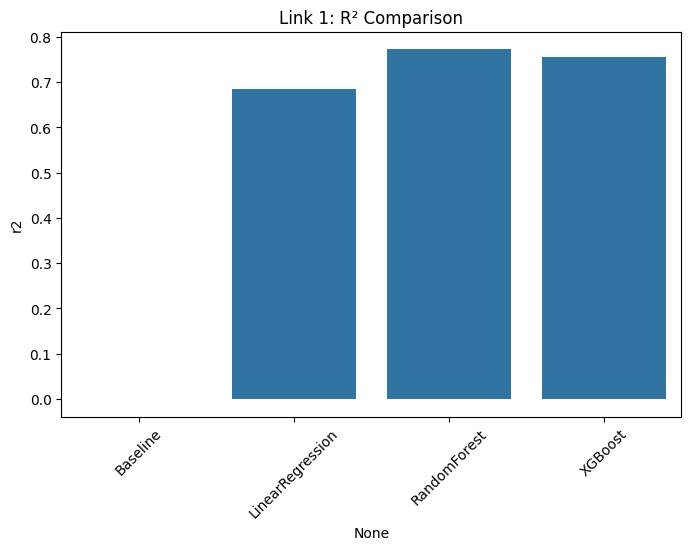

In [ ]:
# plot results
plot_model_comparison(results, 'r2', 'Link 1: R² Comparison')

In [ ]:
# primary food access features (threshold 1/2 and 10 miles)
x = 'LALOWI05_10'

# potential factors for control
confounders = ['Urban', 'POP2010', 'OHU2010', 'GroupQuartersFlag', 'NUMGQTRS', 'LILATracts_1And10', 'LILATracts_halfAnd10', 
     'LILATracts_1And20', 'LILATracts_Vehicle', 'HUNVFlag', 'LowIncomeTracts', 'LAPOP1_10', 'LAPOP05_10', 'LAPOP1_20', 
     'LALOWI1_10', 'LALOWI1_20', 'lapophalf', 'lalowihalf', 'lakidshalf', 'laseniorshalf', 'lawhitehalf', 
     'lablackhalf', 'laasianhalf', 'lanhopihalf', 'laaianhalf', 'laomultirhalf', 'lahisphalf', 'lahunvhalf', 'lasnaphalf', 
     'lapop1', 'lalowi1', 'lakids1', 'laseniors1', 'lawhite1', 'lablack1', 'laasian1', 'lanhopi1', 'laaian1', 'laomultir1', 
     'lahisp1', 'lahunv1', 'lasnap1', 'lapop10', 'lalowi10', 'lakids10', 'laseniors10', 'lawhite10', 'lablack10', 'laasian10', 
     'lanhopi10', 'laaian10', 'laomultir10', 'lahisp10', 'lahunv10', 'lasnap10', 'lapop20', 'lalowi20', 'lakids20', 'laseniors20', 
     'lawhite20', 'lablack20', 'laasian20', 'lanhopi20', 'laaian20', 'laomultir20', 'lahisp20', 'lahunv20', 'lasnap20', 'TractLOWI', 
     'TractKids', 'TractSeniors', 'TractWhite', 'TractBlack', 'TractAsian', 'TractNHOPI', 'TractAIAN', 'TractOMultir', 'TractHisp', 
     'TractHUNV', 'TractSNAP', 'LA1and10', 'LAhalfand10', 'LA1and20', 'LATracts_half', 'LATracts1', 'LATracts10', 'LATracts20', 
     'LATractsVehicle_20', 'PCTGQTRS', 'PovertyRate', 'lapophalfshare', 'lalowihalfshare', 'lakidshalfshare', 'laseniorshalfshare', 
     'lawhitehalfshare', 'lablackhalfshare', 'laasianhalfshare', 'lanhopihalfshare', 'laaianhalfshare', 'laomultirhalfshare', 
     'lahisphalfshare', 'lapop1share', 'lalowi1share', 'lakids1share', 'laseniors1share', 'lawhite1share', 'lablack1share', 
     'laasian1share', 'lanhopi1share', 'laaian1share', 'laomultir1share', 'lahisp1share', 'lapop10share', 'lalowi10share', 
     'lakids10share', 'laseniors10share', 'lawhite10share', 'lablack10share', 'laasian10share', 'lanhopi10share', 'laaian10share', 
     'laomultir10share', 'lahisp10share', 'lapop20share', 'lalowi20share', 'lakids20share', 'laseniors20share', 'lawhite20share', 
     'lablack20share', 'laasian20share', 'lanhopi20share', 'laaian20share', 'laomultir20share', 'lahisp20share', 'lahunv20share', 
     'lahunv10share', 'lahunvhalfshare', 'lahunv1share', 'lasnap20share', 'lasnap10share', 'lasnaphalfshare', 'lasnap1share', 
     'MedianFamilyIncome']

# target var
y = '2015 Food Insecurity Rate'

In [ ]:
corr_X = link1[confounders + [x]].corr()[x].drop(x)
corr_Y = link1[confounders + [y]].corr()[y].drop(y)

corr_df = pd.DataFrame({
    'corr_with_X': corr_X,
    'corr_with_Y': corr_Y
})

# Keep variables correlated with both X and Y (above threshold)
confounders_to_control = corr_df[
    (corr_df['corr_with_X'].abs() > 0.2) &
    (corr_df['corr_with_Y'].abs() > 0.2)
].index.tolist()

corr_df.loc[confounders_to_control]

,corr_with_X,corr_with_Y
lawhitehalfshare,-0.289732,-0.393027
lalowi1share,-0.295356,0.486082
lawhite1share,-0.364120,-0.207294
lasnap1share,-0.208681,0.550525


In [ ]:
# primary food access features (threshold 1/2 and 10 miles)
x = ['LALOWI05_10']

# selected factors for control at threshold
confounders = [
    'lalowihalfshare', 'lalowi10share',      # low income pop share
    'lasnaphalfshare', 'lasnap10share',       # SNAP participation share
    'lawhitehalfshare', 'lawhite10share',     # % white
    'PovertyRate',                          # economic
    'MedianFamilyIncome',                    # economic
    'Urban',                                 # urbanicity
    'lahunvhalfshare', 'lahunv10share',         # households without vehicles
    'lakidshalfshare', 'lakids10share',         # kids
    'laseniorshalfshare', 'laseniors10share'     # seniors
]

X = x + confounders

# target var
y = '2015 Food Insecurity Rate'

In [ ]:
regressions(X, y, link1)

,Model,R²,RMSE
0,Linear Regression,0.687714,0.024427
1,Random Forest,0.733547,0.022563
2,Gradient Boosting,0.731369,0.022655


## Food Insecurity vs. Chronic Illness

**Model Performance:**
1. **Baseline** (DummyRegressor)
- No predictive power, any model is better than the baseline

2. **Linear Regression**
- Explains 55% of variance in the health outcome.
- Captures linear association between food insecurity and health outcomes, but misses nonlinear patterns.

3. **Random Forest**
- Explains 64% variance
- Strongest model with lowest RMSE

4. **XGBoost**
- Explain 61% variance

---
**Summary**:
- Random Forest is again the best-performing model, capturing the nonlinear relationships between food insecurity and health outcomes.
- Linear regression still performs reasonably well and provides interpretability.
- Overall, food insecurity explains a moderate amount of variation in chronic health outcomes (R² ~0.55–0.64).
- The predictive strength is lower than Link 1, suggesting other factors beyond food insecurity contribute to health outcomes more.

In [ ]:
# load data
link2 = pd.read_csv('../data/processed/link2/link2.csv')

In [ ]:
list(link2.columns)

['FIPS',
 'State',
 'County, State',
 '2017 Food Insecurity Rate',
 '# of Food Insecure Persons in 2017',
 'Low Threshold in state',
 'Low Threshold Type',
 'High Threshold in state',
 'High Threshold Type',
 '% FI ≤ Low Threshold',
 '% FI Btwn Thresholds',
 '% FI > High Threshold',
 '2017 Child food insecurity rate',
 '# of Food Insecure Children in 2017',
 '% food insecure children in HH w/ HH incomes below 185 FPL in 2017',
 '% food insecure children in HH w/ HH incomes above 185 FPL in 2017',
 '2017 Cost Per Meal',
 '2017 Weighted Annual Food Budget Shortfall',
 'TotalPopulation',
 'ACCESS2_CrudePrev',
 'ACCESS2_Crude95CI',
 'ACCESS2_AdjPrev',
 'ACCESS2_Adj95CI',
 'ARTHRITIS_CrudePrev',
 'ARTHRITIS_Crude95CI',
 'ARTHRITIS_AdjPrev',
 'ARTHRITIS_Adj95CI',
 'BINGE_CrudePrev',
 'BINGE_Crude95CI',
 'BINGE_AdjPrev',
 'BINGE_Adj95CI',
 'BPHIGH_CrudePrev',
 'BPHIGH_Crude95CI',
 'BPHIGH_AdjPrev',
 'BPHIGH_Adj95CI',
 'BPMED_CrudePrev',
 'BPMED_Crude95CI',
 'BPMED_AdjPrev',
 'BPMED_Adj95CI',


In [ ]:
link2['TotalPopulation'] = link2['TotalPopulation'].str.replace(',', '').astype(int)

### Testing and Comparing Models

In [ ]:
# food insecurity features
X = link2[['2017 Food Insecurity Rate', '# of Food Insecure Persons in 2017', 'Low Threshold in state', 
          'High Threshold in state', '% FI ≤ Low Threshold', 
          '% FI > High Threshold', '2017 Child food insecurity rate', 
          '# of Food Insecure Children in 2017', '% food insecure children in HH w/ HH incomes below 185 FPL in 2017', 
          '% food insecure children in HH w/ HH incomes above 185 FPL in 2017', '2017 Cost Per Meal', 
          '2017 Weighted Annual Food Budget Shortfall', 'TotalPopulation']] 

# target var
y = link2['Chronic_CrudePrev_Mean']

In [ ]:
# pca + test train split
X_train_p, X_test_p, y_train, y_test = pca(X, y)

# model and show results
results = train_and_eval(X_train_p, X_test_p, y_train, y_test)
display(results.round(3))

,r2,rmse,mae
Baseline,-0.009,2.232,1.767
LinearRegression,0.546,1.497,1.138
RandomForest,0.637,1.339,1.020
XGBoost,0.613,1.381,1.053


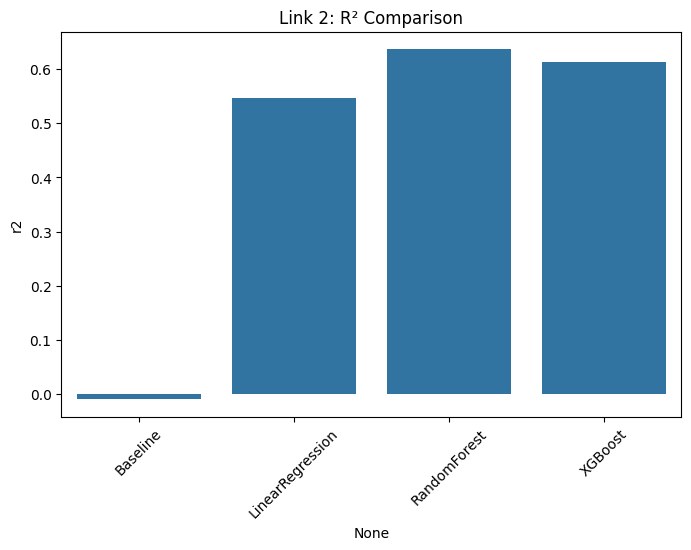

In [ ]:
# plot results
plot_model_comparison(results, 'r2', 'Link 2: R² Comparison')